# Predicting Video Game Sales

## Notes for cleaning dataset
- 269 dates missing, often for Japanese Releases or Atari 2600 games
- 245 dates added, some games seem to have been cancelled for a platform although there are numbers for sales volume, so it's best to sort them out (by Year_Of_Release == None)
- Many games seem to have been released in Japan only => Should be ignored (JP_Sales == Global_Sales otherwise)
- Some games explicitly stated (jp sales/japan sales/etc.) => merged logically with global title, sometimes strong effect; influence of Japan Sales would be missing for some rows otherwise
- Slightly contradictory information for a few rows merged anyway using max(entry1, entry2)
- "tbd" => None
- Fun Fact: River Raid a top seller!

In [1]:
# TODO: use functions
# TODO: clean code
# TODO: visualizations
# TODO: check regressor characteristics

# Import libraries necessary for this project
import numpy as np
import pandas as pd
import scipy as sp
import time

import matplotlib.pyplot as plt

# Allows the use of display() for DataFrames
from IPython.display import display

# sklearn stuff
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import mutual_info_regression, SelectKBest
from sklearn.model_selection import GridSearchCV, ShuffleSplit, train_test_split, learning_curve
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from sklearn import svm

# more stuff
from pandas.tools.plotting import scatter_matrix
from matplotlib import cm
from collections import Counter
from scipy.stats import skew, skewtest

# make pretty
plt.style.use('ggplot')

# Pretty display for notebooks
%matplotlib inline

# Data Schema

## Dataset (Video_Games_Sales_as_at_22_Dec_2016.csv)
This is my main dataset. It will be used to predict video game sales.

| title           | description                                                   | data type |
|-----------------|---------------------------------------------------------------|-----------|
| Name            | Name of the game                                              | String    |
| Platform        | Platform                                                      | String    |
| Year_of_Release | Year of release                                               | Numeric   |
| Genre           | Genre                                                         | String    |
| Publisher       | Publisher                                                     | String    |
| NA_Sales        | Game sales in North America (in millions of units)            | Numeric   |
| EU_Sales        | Game sales in the European Union (in millions of units)       | Numeric   |
| JP_Sales        | Game sales in Japan (in millions of units)                    | Numeric   |
| Other_Sales     | Game sales in the rest of the world (in millions of units)    | Numeric   |
| Global_Sales    | Total sales in the world (in millions of units)               | Numeric   |
| Critic_Score    | Aggregate score compiled by Metacritic staff                  | Numeric   |
| Critic_Count    | The number of critics used in coming up with the Critic_score | Numeric   |
| User_Score      | Score by Metacritic's subscribers                             | Numeric   |
| User_Count      | Number of users who gave the user_score                       | Numeric   |
| Developer       | Party responsible for creating the game                       | String    |
| Rating          | The [ESRB](https://www.esrb.org/) ratings                     | String    |

The next step will be to load the dataset.

In [2]:
def loadDataset(cleaned = True):
    # Load dataset
    if (cleaned):
        try:
            dataset = pd.read_csv("data/Video_Games_Sales_as_at_22_Dec_2016_cleaned.csv")
            #display("Dataset has {} samples with {} possible features.".format(*dataset1.shape))
        except:
            display("Dataset could not be loaded. Is the dataset missing?")
    else:
        try:
            dataset = pd.read_csv("data/Video_Games_Sales_as_at_22_Dec_2016.csv")

            # Some general cleaning that doesn't change any results but makes analysis possible
            
            # tbd to NaN (needed for uncleaned dataset)
            dataset = dataset.copy().replace('tbd', float('NaN'))

            # correct data types (needed for uncleaned dataset)
            dataset['User_Score'] = dataset.copy()['User_Score'].apply(pd.to_numeric)
        except:
            display("Dataset could not be loaded. Is the dataset missing?")
            
    return dataset

In [3]:
def showDatasetInfos(dataset):
    if (~dataset.empty):
        # Display a description of the datasets
        display("Dataset has {} samples with {} possible features.".format(*dataset.shape))
        display('NUMBER OF NaNs')
        display([dataset.shape[0]] * dataset.shape[1] - dataset.count())
        display(dataset.describe())
        display(dataset.head())
        display(dataset.tail())

In [4]:
def sanitizeDatasets(dataset):
    if (~dataset.empty):
        clean_dataset = dataset.copy()

        # beautify strings and kick (needed for uncleaned dataset)
        for i in range(0, len(clean_dataset.axes[1])):
            if (clean_dataset.ix[:,i].dtype == object):
                clean_dataset.ix[:,i] = clean_dataset.ix[:,i].str.strip()

        # Remove rows with empty values, we want full information
        for column in clean_dataset.keys():
            clean_dataset = clean_dataset[clean_dataset[column].notnull()]

        # dataset is now clean, make a copy for possibe use later        
        return clean_dataset
    else:
        return None

In [5]:
def showColumnInfos(inputset):
    dataset = inputset.copy()
    # display some infos
    if (~dataset.empty):
        print ('DATASET ROWS: {}'.format(*dataset.shape))
        for item in dataset.keys():
            print ('Unique values for column \'{}\': {}'.format(item, dataset[item].unique().size))

In [6]:
def createFeaturePlatformManufacturer(inputset):
    dataset = inputset.copy()
    # TODO: proper sanitization    
    if (~dataset.empty):
        # Platform manufacturer based on the platform
        man_microsoft = ['PC', 'X360', 'XB', 'XOne'] # Yes, PC could be argued about
        man_nintendo  = ['3DS', 'DS', 'GBA', 'GC', 'N64', 'Wii', 'WiiU']
        man_sega      = ['DC', 'GEN', 'GG','SAT', 'SCD']
        man_sony      = ['PS', 'PS2', 'PS3', 'PS4', 'PSP', 'PSV']
        man_other     = ['2600', '3DO', 'PCFX', 'TG16', 'WS']

        dataset['Platform_Manufacturer'] = dataset['Platform'].map(lambda x:
            'Microsoft' if x in man_microsoft else
            'Nintendo' if x in man_nintendo else
            'Sega' if x in man_sega else
            'Sony' if x in man_sony else
            'Other' if x in man_other else
            float('NaN'))
        return dataset
    else:
        print ('There is something wrong in createFeaturePlatformManufacturer')
        return None

In [7]:
def createFeatureMobility(inputset):
    dataset = inputset.copy()
    # TODO: proper sanitization
    if (~dataset.empty):
        # Portable based on the platform
        portables = ['3DS', 'DS', 'GBA', 'GG', 'PSP', 'PSV', 'WS']
        stationaries = ['PC', 'X360', 'XB', 'XOne', 'GC', 'N64', 'Wii', 'WiiU', 'DC', 'GEN', 'SAT', 'SCD', 'PS', 'PS2', 'PS3', 'PS4', '2600', '3DO', 'PCFX', 'TG16']
        dataset['Mobility'] = dataset['Platform'].map(lambda x:
                                                      'Portable' if x in portables else 
                                                      'Stationary'if x in stationaries else
                                                      float('NaN'))
        return dataset
    else:
        print ('There is something wrong in createFeaturePortables')
        return None

In [8]:
def convertNominalFeatures(inputset, columns):
    dataset = inputset.copy()
    # TODO: proper sanitization    
    if ((~dataset.empty) & (len(columns) != 0)):
        # create Boolean columns for each nominal variable
        for column in columns:
            if column in dataset.keys():
                for value in dataset[column].unique():
                    dataset[column + '_' + value] = dataset[column].map(lambda x: True if x == value else False)
        return dataset
    else:
        print ('There is something wrong in convertNominalFeatures')
        return None

In [9]:
def separateTargetValues(inputset):
    dataset = inputset.copy()
    # separate features and target values (sales volume)
    sales = pd.DataFrame()
    sales['Global'] = dataset['Global_Sales'].copy()
    sales['NA'] = dataset['NA_Sales'].copy()
    sales['EU'] = dataset['EU_Sales'].copy()
    sales['JP'] = dataset['JP_Sales'].copy()
    sales['Other'] = dataset['Other_Sales'].copy()

    # remove target columns
    features = dataset.drop(['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales'], axis=1)
    
    return features, sales

In [10]:
def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    
    # Calculate the performance score between 'y_true' and 'y_predict'
    score = r2_score(y_true, y_predict)
    
    # Return the score
    return score

In [11]:
# Print the results of prediction for both training and testing
def get_r2(X_train, y_train, X_test, y_test):
    r2_train = performance_metric(y_train, reg.predict(X_train))
    r2_test  = performance_metric(y_test, reg.predict(X_test))

    print "For training set, model has a coefficient of determination, R^2, of {:.4f}.".format(r2_train)
    print "For test set, model has a coefficient of determination, R^2, of {:.4f}.".format(r2_test)
    
    return min(r2_train, r2_test)

In [12]:
def showCorrelations(inputset, threshold = None):
    #TODO: sanitization
    dataset = inputset.copy()
    if ((type(threshold) != float) & (type(threshold) != int)):
        display(dataset.corr())
    else:
        display(dataset.corr()[abs(dataset.corr()) > threshold])

In [13]:
def dropNominalFeatures(inputset):
    dataset = inputset.copy()
    for column in dataset.keys():
        if (dataset[column].dtype == object):
            dataset = dataset.drop(column, axis = 1)
    return dataset

In [14]:
def removeOutliersYear(inputset):
    # There are only few rows before 2000, because MetaCritic was founded in July 16, 1999
    # Also, looking at the sum of global sales grouped by year seamingly reveals a large
    # gap from 2000 to 2001 -- but there probably wasn't such a boost in video game sales, but
    # MetaCritit had to get going. We also have a gap from 2015 to 2016 in the other direction
    # Might be true, might also result from the fact that Christmas is late in the year and
    # games are often sold then which are not yet in the dataset
    # I consider the those rows before 2001 to be outliers to be removed, also those after 2015
    output = inputset[(inputset.Year_of_Release > 2000) & (inputset.Year_of_Release < 2016)]
    print '{} samples remaining after removeOutliersYear().'.format(output.shape[0])
    return output

In [15]:
def removeOutliersJapanOnly(inputset):
    output = inputset[(inputset.JP_Sales != inputset.Global_Sales)]
    print '{} samples remaining after removeOutliersJapanOnly().'.format(output.shape[0])
    return output

In [16]:
def removeOutliers(inputset, columns = None, threshold = 1.5, multeity = 1):  

    dataset = inputset.copy()
    outliers = []
    iter_columns = columns if columns != None else dataset.keys()
    for feature in iter_columns:
        if dataset[feature].dtype == float:
            # Calculate multiple of interquartile range of feature
            q1 = dataset[feature].quantile(0.25)
            q3 = dataset[feature].quantile(0.75)
            step = (q3 - q1) * threshold
            
            outlier_set = dataset[~((dataset[feature] >= q1 - step) & (dataset[feature] <= q3 + step))]
            outliers.extend(outlier_set.index.values)            
            
            # Display the outlier count
            #print "Rows considered outliers for the feature '{}': {}".format(feature, outlier_set.shape[0])
    
    # get outlier indexes to be removed depending on multeity
    counter = Counter(outliers)
    delete_rows = []
    for key in counter:
        if counter[key] >= multeity:
            delete_rows.append(key)

    #print 'Removed {} rows with outliers of multeity {} or above.'.format(len(delete_rows), multeity)
    print '{} samples remaining after removeOutliers().'.format(dataset.shape[0]-len(delete_rows))
    return dataset.drop(pd.Index(delete_rows))

In [17]:
def removeOutliersBundle(inputset, remove_bundles = False):
    # Several titles seem to have sold tremendously, but they came along with Hardware bundles,
    # e.g. "Super Mario Kart Wii" with the Wii or "Kinect Adventures!" with the XBox 360
    # Sad to kick these out, as especially the Mario Games are nice!
    dataset = inputset.copy()

    # Those are the confirmed ones, there may be many more ... 
    if (remove_bundles == False):
        bundleIDs = [0, 2, 3, 6, 7, 8, 11, 13, 14, 15, 16, 19, 23, 26, 28, 29, 32, 34, 35, 36, 37, 39, 40, 41, 44, 49, 51, 53, 54, 60, 61, 62, 64, 66, 68, 69, 73, 74, 75, 77, 79, 80, 84, 91, 92, 97, 100, 103, 105, 110, 111, 116, 117, 118, 121, 125, 126, 127, 129, 134, 136, 140, 141, 143, 147, 149, 150, 154, 162, 164, 165, 173, 176, 185, 190, 197, 200, 201, 204]
    
        dataset['Bundle'] = pd.Series(['unknown'] * (max(dataset.index.values)+1))
        for ID in bundleIDs:
            dataset['Bundle'].ix[ID] = 'bundle'        
    else:
        dataset = dataset[dataset.Name != 'Wii Sports'] # ID 0, e.g. https://www.cnet.com/products/nintendo-wii-original-wii-sports-bundle/prices/
        dataset = dataset[dataset.Name != 'Mario Kart Wii'] # ID 2, e.g. https://www.amazon.de/Nintendo-Wii-Mario-Kart-Pack/dp/B004ZL4LHS
        dataset = dataset[dataset.Name != 'Wii Sports Resort'] #ID 3, e.g. https://www.amazon.de/Nintendo-Wii-Sports-Resort-Pack/dp/B0049USKP4   
        dataset = dataset[dataset.Name != 'New Super Mario Bros.'] # ID 6, e.g. https://www.amazon.com/Nintendo-DS-Limited-Mario-Super-Bros/dp/B001IAT7O6
        dataset = dataset[dataset.Name != 'Wii Play'] # ID 7, e.g. https://www.amazon.com/Wii-Play-Remote/dp/B000KRXAGE
        dataset = dataset[dataset.Name != 'New Super Mario Bros. Wii'] # ID 8, e.g. https://www.amazon.de/Nintendo-Wii-Jubil%C3%A4ums-Pak-Controller/dp/B0046RDYPQ
        dataset = dataset[dataset.Name != 'Mario Kart DS'] # ID 11, e.g. https://www.amazon.de/Nintendo-DS-Konsole-Silber-inkl/dp/B000BSNGWU
        dataset = dataset[dataset.Name != 'Wii Fit'] # ID 13, e.g.
        dataset = dataset[dataset.Name != 'Kinect Adventures!'] # ID 14, e.g. https://www.amazon.de/Xbox-360-Konsole-Adventures-schwarz-matt/dp/B003WUXT9E
        dataset = dataset[dataset.Name != 'Wii Fit Plus'] # ID 15, e.g. e.g. https://www.amazon.de/Nintendo-Wii-Fit-Plus-Pack/dp/B005NAC7QC
        dataset = dataset[dataset.Name != 'Grand Theft Auto V'] # ID 16, ID 23 and , e.g. https://www.amazon.de/PlayStation-Konsole-DualShock-Wireless-Controller/dp/B00DCN0VFQ
        dataset = dataset[dataset.Name != 'Brain Age: Train Your Brain in Minutes a Day'] # ID 19, https://9a3ac732-a-62cb3a1a-s-sites.googlegroups.com/site/sunsetusclub/Home/product-display-3/nintendo-wii---fit/DSC01357.JPG?attachauth=ANoY7crnNRJg5Fy57vJWi_xQsw4nMLh7PLOkKbLzwLgtFYj5LwqlN4in3yJUS2Fv8noneqIMbKTOi1hYSORZd3vyEIuRLSaELzCrxomK-x06aEXM-Hj2LG_BjdrM7VwN-WIQu48XH1CZVKBepvdXzXTRCZ7W9_hBGFXXC0WGkl_qehIfquRCvwB-ICo0Oi7BtyDm_xxeLXKzZ-NPW4L9JrzNQZarDOKF2G4RJ0wzFM7QcGgv6z_YOiceFXuVIcOR-bLwG6NuCDpqNanXr6XXPZPYmuAGcU6ASg%3D%3D&attredirects=0
        dataset = dataset[dataset.Name != 'Brain Age 2: More Training in Minutes a Day'] # ID 26, e.g. http://www.siliconera.com/2007/08/08/the-brain-age-2-bundle/
        dataset = dataset[dataset.Name != 'Gran Turismo 3: A-Spec'] # ID 28, e.g. http://www.gamespot.com/articles/gran-turismo-3-hardware-bundle/1100-2780343/
        dataset = dataset[dataset.Name != 'Call of Duty: Modern Warfare 3'] # ID 29, ID 37, e.g. http://www.ebay.com/p/Sony-PlayStation-3-Call-Of-Duty-Modern-Warfare-3-Bundle-320-GB-Charcoal-Black-Console/114589636
        dataset = dataset[dataset.Name != 'Call of Duty: Black Ops'] # ID 32, ID 41, e.g. https://www.amazon.com/PlayStation-160GB-Call-Duty-Bundle-3/dp/B004XABXY0
        dataset = dataset[dataset.Name != 'Call of Duty: Black Ops II'] # ID 34, ID 35, e.g. https://www.amazon.com/Xbox-360-500GB-Call-Duty-Bundle/dp/B00NNU07RU?th=1
        dataset = dataset[dataset.Name != 'Call of Duty: Modern Warfare 2'] #ID 36, e.g. https://www.amazon.de/Xbox-360-Konsole-Wireless-Controller/dp/B002Q4U7BK
        dataset = dataset[dataset.Name != 'Super Smash Bros. Brawl'] # ID 39, e.g. http://www.ddrgame.com/system-nintendo-wii-brawl-bundle.html
        dataset = dataset[dataset.Name != 'Mario Kart 7'] # ID 40, e.g. https://www.amazon.de/Nintendo-Wii-Mario-Kart-Pack/dp/B004ZL4LHS
        dataset = dataset[dataset.Name != 'Gran Turismo 4'] # ID 41, e.g. https://www.amazon.de/PlayStation-Konsole-Turismo-TouristTrophy-Bundle/dp/B000KG5PJU
        dataset = dataset[dataset.Name != 'Halo 3'] # ID 44, e.g. https://www.engadget.com/2009/08/23/rumor-discount-xbox-360-elite-halo-3-bundle-coming-to-canada/
        dataset = dataset[dataset.Name != 'Super Mario Galaxy'] # ID 49, e.g. http://www.ddrgame.com/system-nintendo-wii-galaxy-bundle.html
        dataset = dataset[dataset.Name != 'Grand Theft Auto IV'] # ID 51, ID 57, e.g. https://www.engadget.com/2009/04/30/canada-gets-exclusive-xbox-360-elite-anniversary-bundle-gta-i/
        dataset = dataset[dataset.Name != 'Super Mario 3D Land'] # ID 53, e.g. http://www.ebay.com/p/Nintendo-3DS-Super-Mario-3D-Land-Flame-Red-Handheld-System/111329135
        dataset = dataset[dataset.Name != 'Gran Turismo 5'] # ID 54, e.g. http://www.sonyinsider.com/2008/10/09/sony-japan-introduces-new-ps3-bundles/    
        dataset = dataset[dataset.Name != 'Call of Duty: Ghosts'] #ID 60, ID 69, e.g. https://www.amazon.de/Xbox-360-inkl-Ghosts-Black/dp/B00NIWFTHQ
        dataset = dataset[dataset.Name != 'Just Dance 3'] # ID 61, e.g. https://www.amazon.com/Nintendo-Wii-Console-Just-Dance-Bundle/dp/B006MBJF16
        dataset = dataset[dataset.Name != 'New Super Mario Bros. 2'] # ID 62, e.g. https://www.amazon.de/Nintendo-2DS-Konsole-inkl-vorinstalliert/dp/B00KR4TIW0
        dataset = dataset[dataset.Name != 'Halo: Reach'] # ID 64, e.g. https://www.amazon.de/Xbox-360-Konsole-Limited-schwarz-gl%C3%A4nzend/dp/B004M1ULCU
        dataset = dataset[dataset.Name != 'Halo 4'] # ID 66, e.g. https://www.amazon.de/Xbox-360-Halo-Bundle-Limitierte/dp/B008M7VEIA
        dataset = dataset[dataset.Name != 'Just Dance 2'] # ID 68, e.g. https://www.amazon.de/Wii-Konsole-inkl-Just-Dance/dp/B0064XFZQG
        dataset = dataset[dataset.Name != 'Animal Crossing: New Leaf'] # ID 73, e.g. https://www.amazon.de/Nintendo-3DS-XL-vorinstalliert-Limitierte/dp/B00CI1VSXM
        dataset = dataset[dataset.Name != 'Mario Party DS'] # ID 74, e.g. http://www.ebay.com/p/Nintendo-DSi-Mario-Party-DS-Bundle-256-MB-Orange-Handheld-System/100252606
        dataset = dataset[dataset.Name != 'The Elder Scrolls V: Skyrim'] # ID 75, e.g. https://www.google.de/imgres?imgurl=https%3A%2F%2Fimg.conrad.de%2Fmedias%2Fglobal%2Fce%2F9000_9999%2F9100%2F9190%2F9195%2F919537_RB_00_FB.EPS_1000.jpg&imgrefurl=https%3A%2F%2Fwww.conrad.de%2Fde%2Fxb360-250-gb-forza-4-skyrim-919537.html&docid=rr6GdKHV1kBeXM&tbnid=I2_OznqscqzkoM%3A&vet=1&w=1000&h=1000&itg=1&safe=off&bih=1110&biw=1846&q=The%20Elder%20Scrolls%20V%3A%20Skyrim%20xbox%20360%20bundle&ved=0ahUKEwj52bq67cbSAhWBxRQKHT_6CagQMwgiKAYwBg&iact=mrc&uact=8#h=1000&imgrc=I2_OznqscqzkoM:&vet=1&w=1000   
        dataset = dataset[dataset.Name != 'FIFA 16'] # ID 77, e.g. https://www.amazon.de/PlayStation-Konsole-500GB-inkl-FIFA/dp/B016142H86
        dataset = dataset[dataset.Name != 'Wii Party'] # ID 79, e.g. https://www.amazon.de/Party-inkl-Remote-Controller-schwarz/dp/B0049RZQ9A
        dataset = dataset[dataset.Name != 'Mario Party 8'] # ID 80, e.g. http://www.ddrgame.com/system-nintendo-wii-party8-bundle.html
        dataset = dataset[dataset.Name != 'Final Fantasy X'] # ID 84, e.g. http://www.sealedgameheaven.com/index.php?/topic/2549-ps2-rare-bundles/
        dataset = dataset[dataset.Name != 'Grand Theft Auto: Liberty City Stories'] # ID 91, e.g. https://www.amazon.de/PlayStation-Portable-Konsole-Stories-Bundle/dp/B000JMJZQY
        dataset = dataset[dataset.Name != 'Call of Duty: Advanced Warfare'] # ID 92, e.g. https://www.playstation.com/en-us/explore/ps4/systems/call-of-duty-infinite-warfare-ps4-bundle
        dataset = dataset[dataset.Name != 'Super Mario Galaxy 2'] # ID 97, e.g. http://www.ddrgame.com/system-nintendo-wii-super-mario-galaxy-2-bundle.html    
        dataset = dataset[dataset.Name != 'Call of Duty: World at War'] # ID 100 (X360), e.g. http://www.terapeak.com/worth/microsoft-xbox-360-slim-4gb-matte-black-console-bundle-with-call-of-duty-mw3/161144318028/
        dataset = dataset[dataset.Name != 'Need for Speed Underground'] # ID 103 (PS2), https://www.youtube.com/watch?v=mzuJ_Gsdnzw
        dataset = dataset[dataset.Name != 'Fallout 4'] # ID 105, e.g. http://www.chip.de/news/PlayStation-4-inklusive-Fallout-4-Total-verstrahlter-Tiefpreis-bei-Media-Markt_85439279.html
        dataset = dataset[dataset.Name != 'Mario Kart 8'] # ID 110 (WiiU), https://www.amazon.de/Mario-Kart-Premium-Pack-schwarz/dp/B00JXCBOUQ
        dataset = dataset[dataset.Name != 'Super Smash Bros. Melee'] # ID 111 (GC), https://www.youtube.com/watch?v=pgSuNUNz-vQ
        dataset = dataset[dataset.Name != 'Just Dance 4'] # ID 116 (Wii), http://www.play-asia.com/nintendo-wii-console-white-just-dance-4-bundle/13/705wmv
        dataset = dataset[dataset.Name != 'Gears of War 2'] # ID 117 (X360), e.g. http://kotaku.com/5268531/both-gears-of-war-games-bundled-with-360-hardware
        dataset = dataset[dataset.Name != "Uncharted 3: Drake's Deception"] # ID 118 (PS3), http://us.playstation.com/ps3/systems/uncharted3-playstation-plus-bundle.html
        dataset = dataset[dataset.Name != 'Uncharted 2: Among Thieves'] # ID 121 (PS3), e.g. https://www.amazon.co.uk/Sony-PlayStation-Console-250GB-Uncharted/dp/B002S0OCYA%3FSubscriptionId%3DAKIAI7JOR3YDFD2IMMWA%26tag%3Dplaystationgamesuk-21%26linkCode%3Dxm2%26camp%3D2025%26creative%3D165953%26creativeASIN%3DB002S0OCYA
        dataset = dataset[dataset.Name != 'Red Dead Redemption'] # ID 125 (PS3), e.g. https://www.zavvi.com/games/consoles/playstation-3-ps3-slim-120gb-console-bundle-including-red-dead-redemption-2m-hdmi-cable/10178108.html    
        dataset = dataset[dataset.Name != 'FIFA 14'] # ID 126 (PS3), e.g. https://www.amazon.de/PlayStation-Konsole-inkl-FIFA-14/dp/B00L198C3G
        dataset = dataset[dataset.Name != "Assassin's Creed III"] # ID 127 (PS3), e.g. https://www.amazon.de/PlayStation-DualShock-Wireless-Controller-Assassins/dp/B009KIZ3P0
        dataset = dataset[dataset.Name != 'Halo: Combat Evolved'] # ID 129 (XB), e.g. https://www.youtube.com/watch?v=G_eq77AXsyQ
        dataset = dataset[dataset.Name != 'Halo 3: ODST'] # ID 134 (X360), https://techcrunch.com/2009/09/16/there-will-be-a-halo-3-odst-xbox-360-bundle/
        dataset = dataset[dataset.Name != 'Super Mario Sunshine'] # ID 136 (GC), e.g. https://www.amazon.com/SuperMario-Sunshine-Gamecube-Bundle/dp/B00006JZC5
        dataset = dataset[dataset.Name != 'Gears of War 3'] # ID 140 (X360), e.g. https://www.gamexchange.co.uk/trade-in-sell/xbox-360-320gb-gears-of-war-limited-edition
        dataset = dataset[dataset.Name != 'Kinect Sports'] # ID 141 (X360), e.g. https://www.amazon.de/Xbox-Kinect-Sports-Bundle-Limitierte/dp/B006ZYJNQW
        dataset = dataset[dataset.Name != 'FIFA 15'] # ID 143 (PS4), e.g. https://www.amazon.de/PlayStation-Konsole-inkl-FIFA-15/dp/B00MHRN1Q4
        dataset = dataset[dataset.Name != 'Metal Gear Solid 4: Guns of the Patriots'] # ID 147 (PS3), e.g. https://www.amazon.com/PlayStation-80GB-Metal-Gear-Solid-3/dp/B0014WJ78E
        dataset = dataset[dataset.Name != 'The Last of Us'] # ID 149 (PS3), e.g. https://www.amazon.de/PlayStation-Konsole-DualShock-Wireless-Controller/dp/B00CABVR4K
        dataset = dataset[dataset.Name != 'LittleBigPlanet'] # ID 150 (PS3), e.g. https://www.amazon.de/Playstation-Konsole-Wireless-Controller-Little/dp/B001ELK9QE
        dataset = dataset[dataset.Name != 'Destiny'] # ID 154 (PS4), e.g. https://www.amazon.de/PlayStation-4-Konsole-inkl-Destiny/dp/B00L198DYY
        dataset = dataset[dataset.Name != 'Forza Motorsport 3'] # ID 162 (X360), e.g. https://www.amazon.de/Xbox-360-Konsole-Crysis-schwarz-matt/dp/B005HSX6G0
        dataset = dataset[dataset.Name != 'Batman: Arkham City'] # ID 164 (PS3), e.g. https://www.zavvi.com/games/consoles/playstation-3-ps3-slim-320gb-console-bundle-includes-batman-arkham-city-and-karate-kid-2010-blu-ray/10574121.html
        dataset = dataset[dataset.Name != 'Monster Hunter Freedom Unite'] # ID 165 (PSP), e.g. https://www.youtube.com/watch?v=ZUe6yA2QwPI
        dataset = dataset[dataset.Name != 'Final Fantasy XIII'] # ID 173 (PS3), e.g. http://www.ebay.com/p/sony-playstation-3-slim-final-fantasy-xiii-lightning-edition-bundle-250gb-ceramic-white-console/110615341
        dataset = dataset[dataset.Name != 'Final Fantasy X-2'] # ID 176 (PS2), e.g. http://www.ebay.com/itm/PS2-Final-Fantasy-XI-Online-40GB-HDD-Hard-Disk-Drive-Bundle-New-Sealed-/381963188016?hash=item58eec7b730:g:7BUAAOSwLF1X-the
        dataset = dataset[dataset.Name != 'New Super Mario Bros. U'] # ID 185 (WiiU), e.g. http://www.siliconera.com/2013/09/23/new-wii-u-bundle-for-japan-includes-32gb-console-mario-u-and-wii-party-u/
        dataset = dataset[dataset.Name != 'FIFA Soccer 13'] # ID 190 (X360), e.g. https://www.zavvi.com/games/consoles/xbox-360-250gb-bundle-includes-fifa-13/10634086.html
        dataset = dataset[dataset.Name != 'Fable III'] # ID 197 (X360), e.g. https://www.amazon.de/Xbox-360-Konsole-Limited-schwarz-gl%C3%A4nzend/dp/B004M1ULCU
        dataset = dataset[dataset.Name != 'The Legend of Zelda: Phantom Hourglass'] # ID 200 (DS), e.g. http://lintoexperiment.blogspot.de/2012/02/nintendo-ds-lite-limited-editions.html
        dataset = dataset[dataset.Name != 'FIFA Soccer 11'] # ID 201 (PS3), e.g. http://www.carigames.pro/ps3-bundle-fifa-13/
        dataset = dataset[dataset.Name != 'Grand Theft Auto: Vice City Stories'] # ID 204 (PSP), e.g. https://images-eu.ssl-images-amazon.com/images/I/415VXBC%2BAoL.jpg
    
    print '{} samples remaining after removeOutliersBundle().'.format(dataset.shape[0])
    return dataset

In [84]:
def displayLearningCurve(X, y, regressor, n_splits, test_size, random_state, params = None, filename = None):
    # create 10 cross-validation sets for training and testing
    cv = ShuffleSplit(n_splits = n_splits, test_size = test_size, random_state = random_state)

    # generate the training set sizes increasing by 50
    train_sizes = np.rint(np.linspace(1, X.shape[0]*0.8 - 1, 9)).astype(int)

    # Create the figure window
    fig = plt.figure(figsize=(10,7))

    # Calculate the training and testing scores
    sizes, train_scores, test_scores = learning_curve(regressor, X, y, cv = cv, train_sizes = train_sizes, scoring = 'r2')

    # Find the mean and standard deviation for smoothing
    train_std = np.std(train_scores, axis = 1)
    train_mean = np.mean(train_scores, axis = 1)
    test_std = np.std(test_scores, axis = 1)
    test_mean = np.mean(test_scores, axis = 1)

    # Subplot the learning curve
    ax = fig.add_subplot(1,1,1)
    ax.plot(sizes, train_mean, 'o-', color = 'r', label = 'Training Score')
    ax.plot(sizes, test_mean, 'o-', color = 'g', label = 'Testing Score')
    ax.fill_between(sizes, train_mean - train_std, train_mean + train_std, alpha = 0.15, color = 'r')
    ax.fill_between(sizes, test_mean - test_std, test_mean + test_std, alpha = 0.15, color = 'g')

    # Labels
    ax.set_title('%s'%(regressor))
    ax.set_xlabel('Number of Training Points')
    ax.set_ylabel('Score')
    ax.set_xlim([0, X.shape[0]*0.8])
    ax.set_ylim([-0.05, 1.05])

    # Visual aesthetics
    #ax.legend(bbox_to_anchor=(1.05, 2.05), loc='lower left', borderaxespad = 0.)
    fig.suptitle('Regressor Learning Performances', fontsize = 16, y = 1.03)
    fig.tight_layout()
    fig.show()
    if (type(filename) == str):
        fig.savefig(filename)

In [19]:
def standardizeDataFrame(dataset):
    scaler = StandardScaler().fit(dataset)
    data = scaler.transform(dataset)
    return pd.DataFrame(data = data, index = dataset.index, columns = dataset.keys()), scaler

In [20]:
def scaleDataFrame(dataset):
    scaler = MinMaxScaler().fit(dataset)
    data = scaler.transform(dataset)
    return pd.DataFrame(data = data, index = dataset.index, columns = dataset.keys()), scaler

In [21]:
def unscaleDataFrame(dataset, scaler):
    data = scaler.inverse_transform(dataset)
    return pd.DataFrame(data = data, index = dataset.index, columns = dataset.keys())

In [22]:
def showKBest(input_features, target, k = 5):
    features = input_features.copy()
    features_new = SelectKBest(mutual_info_regression, k=5).fit_transform(features, target)
    display(pd.DataFrame(features_new).head())

In [23]:
def boxcoxSeries(series, lmbda = None, shift = 1):
    if (series.dtype == object):
        return series, None
    return sp.stats.boxcox(series + shift, lmbda)

In [24]:
def boxcoxDataFrame(inputframe, lmbdas = None, columns = None, shift = 1):
    boxcox_dataframe = pd.DataFrame(index = inputframe.index, columns = inputframe.keys())
    boxcox_lmbdas = {}
    for feature in inputframe.keys():
        # I might want to clean up this mess ...
        if (columns == None):
            lmbdas2 = None if (lmbdas == None) else lmbdas[feature]
            boxcoxed = boxcoxSeries(inputframe[feature], lmbdas2, shift)
            boxcox_dataframe[feature] = boxcoxed[0] if (type(boxcoxed) == tuple) else boxcoxed
            boxcox_lmbdas[feature] = boxcoxed[1] if (lmbdas == None) else None
        elif (feature in columns):
            lmbdas2 = None if (lmbdas == None) else lmbdas[feature]
            boxcoxed = boxcoxSeries(inputframe[feature], lmbdas2, shift)
            boxcox_dataframe[feature] = boxcoxed[0] if (type(boxcoxed) == tuple) else boxcoxed
            boxcox_lmbdas[feature] = boxcoxed[1] if (lmbdas == None) else None                
        else:
            boxcox_dataframe[feature] = inputframe[feature]
            boxcox_lmbdas[feature] = None
    return boxcox_dataframe, boxcox_lmbdas

In [25]:
def unboxcoxSeries(series, lmbda, shift = 1):
    if (series.dtype == object):
        return series
    if ((lmbda == None) | ((type(lmbda) != np.float64) & (type(lmbda) != float))):
        return series
    if (lmbda == 0):
        return pd.Series(np.exp(series))
    else:
        return pd.Series(np.exp(np.log(lmbda * series + 1) / lmbda) - shift)

In [26]:
def unboxcoxDataFrame(inputframe, lmbdas, columns = None, shift = 1):
    if ((lmbdas == None) | (type(lmbdas) != dict)):
        return inputframe
    boxcox_dataframe = pd.DataFrame(index = inputframe.index, columns = inputframe.keys())
    for feature in inputframe.keys():
        if (columns == None):
            boxcox_dataframe[feature] = unboxcoxSeries(inputframe[feature], lmbdas[feature], shift)
        elif (feature in columns):
            boxcox_dataframe[feature] = unboxcoxSeries(inputframe[feature], lmbdas[feature], shift)
        else:
            boxcox_dataframe[feature] = inputframe[feature]
    return boxcox_dataframe

In [27]:
def fit_model(X, y, regressor, params, n_splits, test_size, random_state):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    cv_sets = ShuffleSplit(n_splits = n_splits, test_size = test_size, random_state = random_state)

    # Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric)

    # Create the grid search object
    grid = GridSearchCV(regressor, params, scoring=scoring_fnc, cv=cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)
    
    # Return the optimal model after fitting the data

    return grid.best_estimator_

In [28]:
def getScores(X_train, y_train, X_test, y_test, regressor, params, n_splits, test_size, random_state):
    reg = fit_model(X_train, y_train, regressor, params, n_splits, test_size, random_state)
    reg_score_train = performance_metric(y_train, reg.predict(X_train))
    reg_score_test = performance_metric(y_test, reg.predict(X_test))
    reg_gap = abs(reg_score_train - reg_score_test)
    return reg, reg_score_train, reg_score_test, reg_gap

In [29]:
def computeSkewness(dataframe):
    for feature in dataframe.keys():
        if dataframe[feature].dtype != object:
            print 'skewness for {} is: {} (p={})'.format(feature, skew(dataframe[feature]), skewtest(dataframe[feature])[1])

In [30]:
def plotScoreComparison(dataset, filename = None):

    fig = plt.figure(figsize=(12,6))

    # General comparison
    ax = fig.add_subplot(111, xlim=(-2.5,102.5), ylim=(-2.5,102.5), title='Critic Score and User Score\n', aspect=1)
    ax.set_xlabel('Critic Score')
    ax.set_ylabel('User Score')
    ax.plot(dataset.Critic_Score, dataset.User_Score, marker='.', linestyle='')

    plt.show()
    if (type(filename) == str):
        fig.savefig(filename)

In [31]:
def plotSalesByGroup(dataset, filename = None):
    fig = plt.figure(figsize=(12,17))

    colset=cm.Set1(np.arange(10)/10.)
    
    if ('Genre' in dataset.keys()):
        ax = fig.add_subplot(321, title='Global Sales\nby Genre', aspect=1)
        groups = dataset.groupby('Genre')
        patches, texts = plt.pie(groups.Global_Sales.sum().values.tolist(), labels=groups.Global_Sales.sum().keys().tolist(), colors=colset)

    if ('Rating' in dataset.keys()):
        ax = fig.add_subplot(322, title='Global Sales\nby Rating', aspect=1)
        groups = dataset.groupby('Rating')
        patches, texts = plt.pie(groups.Global_Sales.sum().values.tolist(), labels=groups.Global_Sales.sum().keys().tolist(), colors=colset)

    if ('Platform' in dataset.keys()):
        ax = fig.add_subplot(323, title='Global Sales\nby Platform', aspect=1)
        groups = dataset.groupby('Platform')
        patches, texts = plt.pie(groups.Global_Sales.sum().values.tolist(), labels=groups.Global_Sales.sum().keys().tolist(), colors=colset)

    if ('Platform_Manufacturer' in dataset.keys()):
        ax = fig.add_subplot(324, title='Global Sales\nby Platform Manufacturer', aspect=1)
        groups = dataset.groupby('Platform_Manufacturer')
        patches, texts = plt.pie(groups.Global_Sales.sum().values.tolist(), labels=groups.Global_Sales.sum().keys().tolist(), colors=colset)

    if ('Mobility' in dataset.keys()):        
        ax = fig.add_subplot(325, title='Global Sales\nby Mobility', aspect=1)
        groups = dataset.groupby('Mobility')
        patches, texts = plt.pie(groups.Global_Sales.sum().values.tolist(), labels=groups.Global_Sales.sum().keys().tolist(), colors=colset)

    plt.show()
    if (type(filename) == str):
        fig.savefig(filename)

In [32]:
def plotDistributions(dataset, filename = None):
    matrix_dataset = dataset[['Critic_Score', 'Critic_Count', 'User_Score', 'User_Count', 'Global_Sales']]
    axes = scatter_matrix(matrix_dataset, alpha=0.2, figsize=(12, 7), diagonal='kde')
    plt.suptitle('Distributions', fontsize=16)
    if (type(filename) == str):
        plt.savefig(filename)

In [33]:
def plotCorrelationsSales(dataset, filename = None):
    matrix_dataset = dataset[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']]
    axes = scatter_matrix(matrix_dataset, alpha=0.2, figsize=(12, 12), diagonal='kde')
    plt.suptitle('Correlations', fontsize=16)
    if (type(filename) == str):
        plt.savefig(filename)

In [34]:
def plotScoresVsSales(dataset, filename = None):
    fig = plt.figure(figsize=(12,6))

    # Critic Score vs. Global Sales
    maxy = dataset['Global_Sales'].max() + 5
    ax = fig.add_subplot(121, xlim=(-2.5,102.5), ylim=(-2.5, maxy), title='Critic Score vs. Global Sales\n')
    ax.set_xlabel('Critic Score')
    ax.set_ylabel('Global Sales')
    ax.plot(dataset.Critic_Score, dataset.Global_Sales, marker='.', linestyle='')

    # User Score vs. Global Sales
    ax = fig.add_subplot(122, xlim=(-2.5,102.5), ylim=(-2.5, maxy), title='User Score vs. Global Sales\n')
    ax.set_xlabel('User Score')
    ax.set_ylabel('Global Sales')
    ax.plot(dataset.User_Score, dataset.Global_Sales, marker='.', linestyle='')    

    plt.show()
    if (type(filename) == str):
        fig.savefig(filename)

In [35]:
def prepare_sets(standardize_set, scale_set_0_1, boxcox_set, remove_bundles, outlier_threshold, outlier_multiety, n_splits, test_size, random_state):
       
    dataset = loadDataset()
    clean_dataset = sanitizeDatasets(raw_dataset)
    short_dataset = clean_dataset.copy()
    
    short_dataset = removeOutliersYear(short_dataset.copy())
    short_dataset = removeOutliersJapanOnly(short_dataset.copy())    
    short_dataset = removeOutliersBundle(short_dataset.copy(), remove_bundles)
   
    short_dataset = createFeaturePlatformManufacturer(short_dataset)
    short_dataset = createFeatureMobility(short_dataset)   
    short_dataset = short_dataset.drop(['Name', 'Publisher', 'Developer'], axis=1)
    short_dataset = convertNominalFeatures(short_dataset, ['Mobility', 'Platform', 'Genre', 'Rating', 'Platform_Manufacturer', 'Bundle'])
    short_dataset = dropNominalFeatures(short_dataset)
    
    if (standardize_set == True):
        short_dataset, std_scaler = standardizeDataFrame(short_dataset)
    if (scale_set_0_1 == True):
        short_dataset, minmax_scaler = scaleDataFrame(short_dataset)
    if (boxcox_set == True):
        short_dataset, boxcox_lmbdas = boxcoxDataFrame(short_dataset.copy(), columns=['Critic_Score', 'User_Score'])       

    if (outlier_threshold > 0):
        short_dataset = removeOutliers(short_dataset.copy(), columns = ['Year_of_Release', 'Critic_Score', 'Critic_Count', 'User_Score', 'User_Count','Global_Sales'], threshold = outlier_threshold, multeity = outlier_multiety)            
        
    features, sales = separateTargetValues(short_dataset)
    
    return train_test_split(features, sales['Global'], test_size = test_size, random_state = random_state)

## Begin of analysis

In [36]:
dataset = loadDataset()

In [37]:
showCorrelations(dataset, 0.7)
computeSkewness(pd.DataFrame(dataset))
print '\nMEAN'
print dataset.mean()
print '\nMEDIAN'
print dataset.median()
showDatasetInfos(dataset)

,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count
Year_of_Release,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NA_Sales,NaN,1.000000,0.765527,NaN,NaN,0.941095,NaN,NaN,NaN,NaN
EU_Sales,NaN,0.765527,1.000000,NaN,0.722731,0.901258,NaN,NaN,NaN,NaN
JP_Sales,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
Other_Sales,NaN,NaN,0.722731,NaN,1.000000,0.749167,NaN,NaN,NaN,NaN
Global_Sales,NaN,0.941095,0.901258,NaN,0.749167,1.000000,NaN,NaN,NaN,NaN
Critic_Score,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
Critic_Count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
User_Score,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
User_Count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


skewness for Year_of_Release is: nan (p=nan)
skewness for NA_Sales is: 18.7295267 (p=0.0)
skewness for EU_Sales is: 18.796104035 (p=0.0)
skewness for JP_Sales is: 11.1735891291 (p=0.0)
skewness for Other_Sales is: 24.5088587887 (p=0.0)
skewness for Global_Sales is: 17.3238851834 (p=0.0)
skewness for Critic_Score is: nan (p=nan)
skewness for Critic_Count is: nan (p=nan)
skewness for User_Score is: nan (p=nan)
skewness for User_Count is: nan (p=nan)

MEAN
Year_of_Release    2006.473129
NA_Sales              0.264786
EU_Sales              0.145962
JP_Sales              0.078023
Other_Sales           0.047637
Global_Sales          0.536665
Critic_Score         68.967679
Critic_Count         26.360821
User_Score            7.125046
User_Count          162.229908
dtype: float64

MEDIAN
Year_of_Release    2007.00
NA_Sales              0.08
EU_Sales              0.02
JP_Sales              0.00
Other_Sales           0.01
Global_Sales          0.17
Critic_Score         71.00
Critic_Count        

'Dataset has 16603 samples with 16 possible features.'

'NUMBER OF NaNs'

Name                  2
Platform              0
Year_of_Release      24
Genre                 2
Publisher            51
NA_Sales              0
EU_Sales              0
JP_Sales              0
Other_Sales           0
Global_Sales          0
Critic_Score       8466
Critic_Count       8466
User_Score         9013
User_Count         9013
Developer          6507
Rating             6653
dtype: int64

,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count
count,16579.000000,16603.000000,16603.000000,16603.000000,16603.000000,16603.000000,8137.000000,8137.000000,7590.000000,7590.000000
mean,2006.473129,0.264786,0.145962,0.078023,0.047637,0.536665,68.967679,26.360821,7.125046,162.229908
std,5.932192,0.815941,0.504897,0.309813,0.187323,1.552928,13.938165,18.980495,1.500006,561.282326
min,1977.000000,0.000000,0.000000,0.000000,0.000000,0.010000,13.000000,3.000000,0.000000,4.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,0.060000,60.000000,12.000000,6.400000,10.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,0.170000,71.000000,21.000000,7.500000,24.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,0.470000,79.000000,36.000000,8.200000,81.000000
max,2020.000000,41.360000,28.960000,10.220000,10.570000,82.530000,98.000000,113.000000,9.700000,10665.000000


,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8.0,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8.0,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
16598,XI Coliseum,PSP,2006.0,Puzzle,Sony Computer Entertainment,0.0,0.00,0.01,0.0,0.01,NaN,NaN,NaN,NaN,NaN,NaN
16599,Yattaman Wii: BikkuriDokkiri Machine de Mou Ra...,Wii,2008.0,Racing,Takara Tomy,0.0,0.00,0.01,0.0,0.01,NaN,NaN,NaN,NaN,NaN,NaN
16600,Zero no Tsukaima: Maigo no Period to Ikusen no...,PS2,2008.0,Adventure,Marvelous Interactive,0.0,0.00,0.01,0.0,0.01,NaN,NaN,NaN,NaN,NaN,NaN
16601,Zettai Kaikyuu Gakuen: Eden with Roses and Pha...,PSV,2016.0,Adventure,Prototype,0.0,0.00,0.01,0.0,0.01,NaN,NaN,NaN,NaN,NaN,NaN
16602,ZombiU,XOne,2016.0,Action,Ubisoft,0.0,0.01,0.00,0.0,0.01,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
# Infos
showColumnInfos(dataset)

DATASET ROWS: 16603
Unique values for column 'Name': 11435
Unique values for column 'Platform': 31
Unique values for column 'Year_of_Release': 43
Unique values for column 'Genre': 13
Unique values for column 'Publisher': 580
Unique values for column 'NA_Sales': 402
Unique values for column 'EU_Sales': 307
Unique values for column 'JP_Sales': 244
Unique values for column 'Other_Sales': 155
Unique values for column 'Global_Sales': 629
Unique values for column 'Critic_Score': 83
Unique values for column 'Critic_Count': 107
Unique values for column 'User_Score': 96
Unique values for column 'User_Count': 889
Unique values for column 'Developer': 1697
Unique values for column 'Rating': 9


In [39]:
# Feature Generation and further harmonizing data

# make a dataset that will contain all rows considered for further analysis
raw_dataset = dataset.copy()

#rescale column for human readability, doesn't change anything for analysis
raw_dataset['User_Score'] = raw_dataset['User_Score'] * 10

showDatasetInfos(raw_dataset)

'Dataset has 16603 samples with 16 possible features.'

'NUMBER OF NaNs'

Name                  2
Platform              0
Year_of_Release      24
Genre                 2
Publisher            51
NA_Sales              0
EU_Sales              0
JP_Sales              0
Other_Sales           0
Global_Sales          0
Critic_Score       8466
Critic_Count       8466
User_Score         9013
User_Count         9013
Developer          6507
Rating             6653
dtype: int64

,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count
count,16579.000000,16603.000000,16603.000000,16603.000000,16603.000000,16603.000000,8137.000000,8137.000000,7590.000000,7590.000000
mean,2006.473129,0.264786,0.145962,0.078023,0.047637,0.536665,68.967679,26.360821,71.250461,162.229908
std,5.932192,0.815941,0.504897,0.309813,0.187323,1.552928,13.938165,18.980495,15.000061,561.282326
min,1977.000000,0.000000,0.000000,0.000000,0.000000,0.010000,13.000000,3.000000,0.000000,4.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,0.060000,60.000000,12.000000,64.000000,10.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,0.170000,71.000000,21.000000,75.000000,24.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,0.470000,79.000000,36.000000,82.000000,81.000000
max,2020.000000,41.360000,28.960000,10.220000,10.570000,82.530000,98.000000,113.000000,97.000000,10665.000000


,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,80.0,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,83.0,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,80.0,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
16598,XI Coliseum,PSP,2006.0,Puzzle,Sony Computer Entertainment,0.0,0.00,0.01,0.0,0.01,NaN,NaN,NaN,NaN,NaN,NaN
16599,Yattaman Wii: BikkuriDokkiri Machine de Mou Ra...,Wii,2008.0,Racing,Takara Tomy,0.0,0.00,0.01,0.0,0.01,NaN,NaN,NaN,NaN,NaN,NaN
16600,Zero no Tsukaima: Maigo no Period to Ikusen no...,PS2,2008.0,Adventure,Marvelous Interactive,0.0,0.00,0.01,0.0,0.01,NaN,NaN,NaN,NaN,NaN,NaN
16601,Zettai Kaikyuu Gakuen: Eden with Roses and Pha...,PSV,2016.0,Adventure,Prototype,0.0,0.00,0.01,0.0,0.01,NaN,NaN,NaN,NaN,NaN,NaN
16602,ZombiU,XOne,2016.0,Action,Ubisoft,0.0,0.01,0.00,0.0,0.01,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
# Show correlations between all variables
showCorrelations(raw_dataset, 0.7)

,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count
Year_of_Release,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NA_Sales,NaN,1.000000,0.765527,NaN,NaN,0.941095,NaN,NaN,NaN,NaN
EU_Sales,NaN,0.765527,1.000000,NaN,0.722731,0.901258,NaN,NaN,NaN,NaN
JP_Sales,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
Other_Sales,NaN,NaN,0.722731,NaN,1.000000,0.749167,NaN,NaN,NaN,NaN
Global_Sales,NaN,0.941095,0.901258,NaN,0.749167,1.000000,NaN,NaN,NaN,NaN
Critic_Score,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
Critic_Count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
User_Score,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
User_Count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In order to understand the dataset better, we should have a look at possible values.

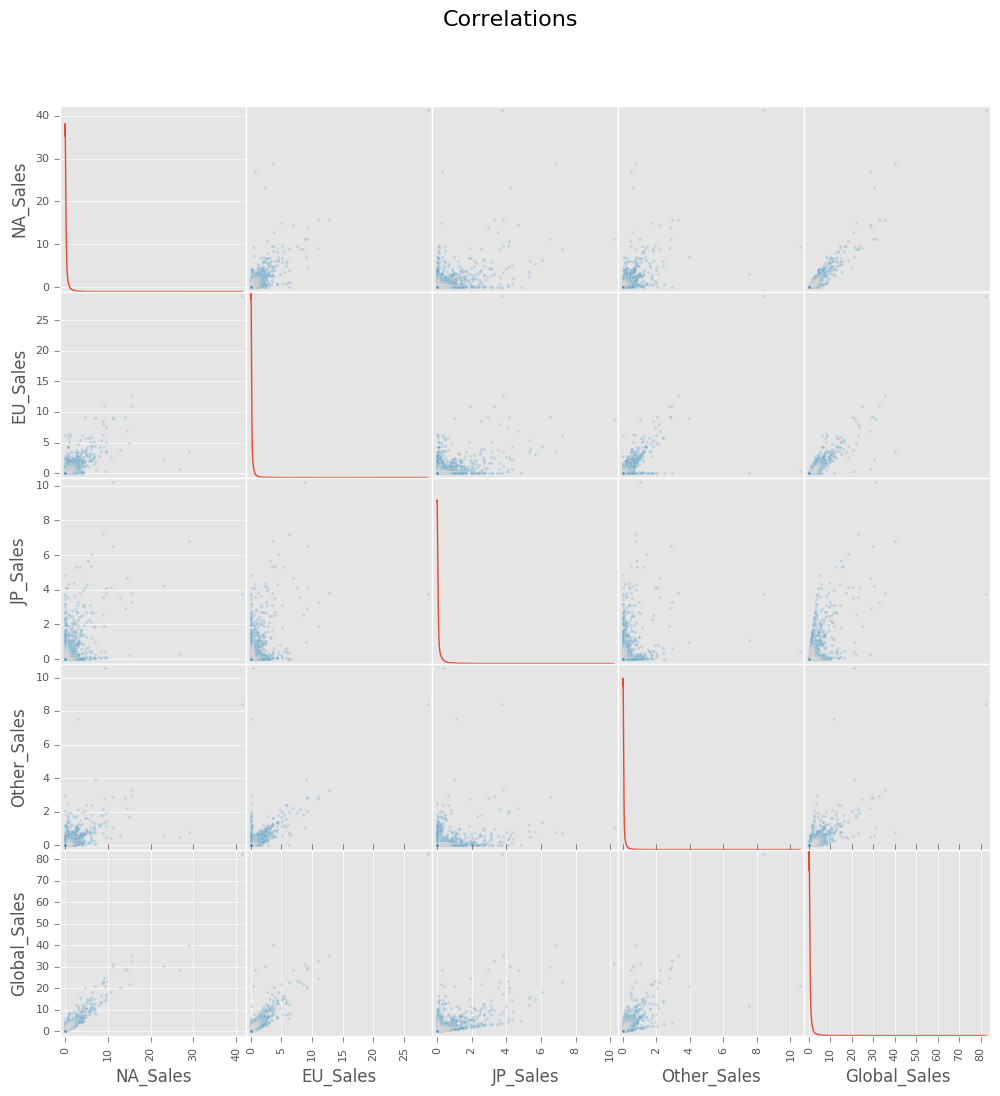

In [41]:
plotCorrelationsSales(raw_dataset, 'viz/correlations.png')

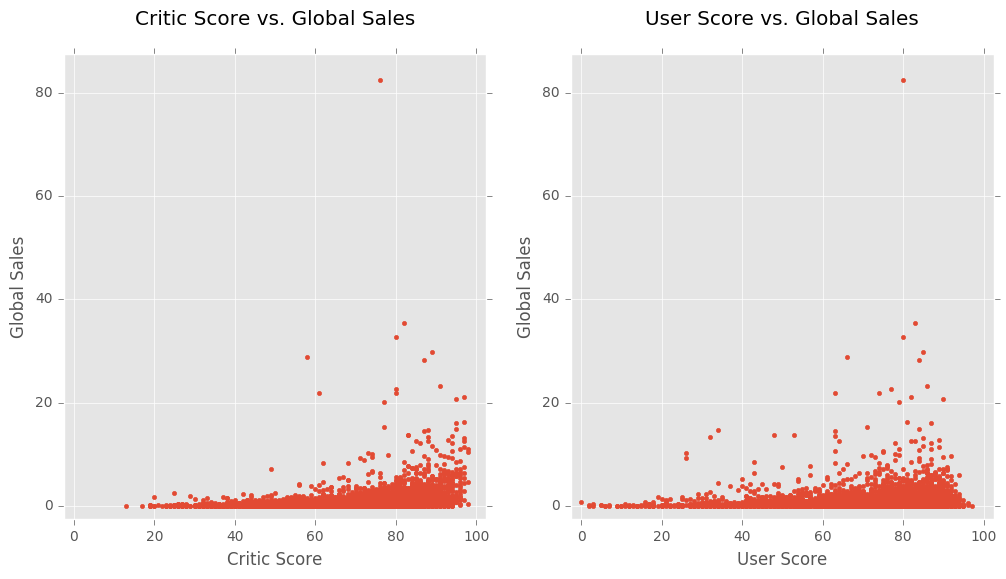

In [42]:
plotScoresVsSales(raw_dataset, 'viz/scores_vs_sales.png')

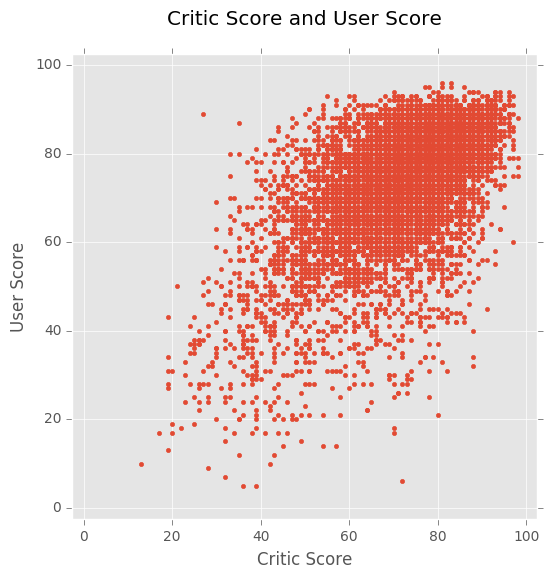

In [43]:
plotScoreComparison(raw_dataset, 'viz/score_comparison.png')

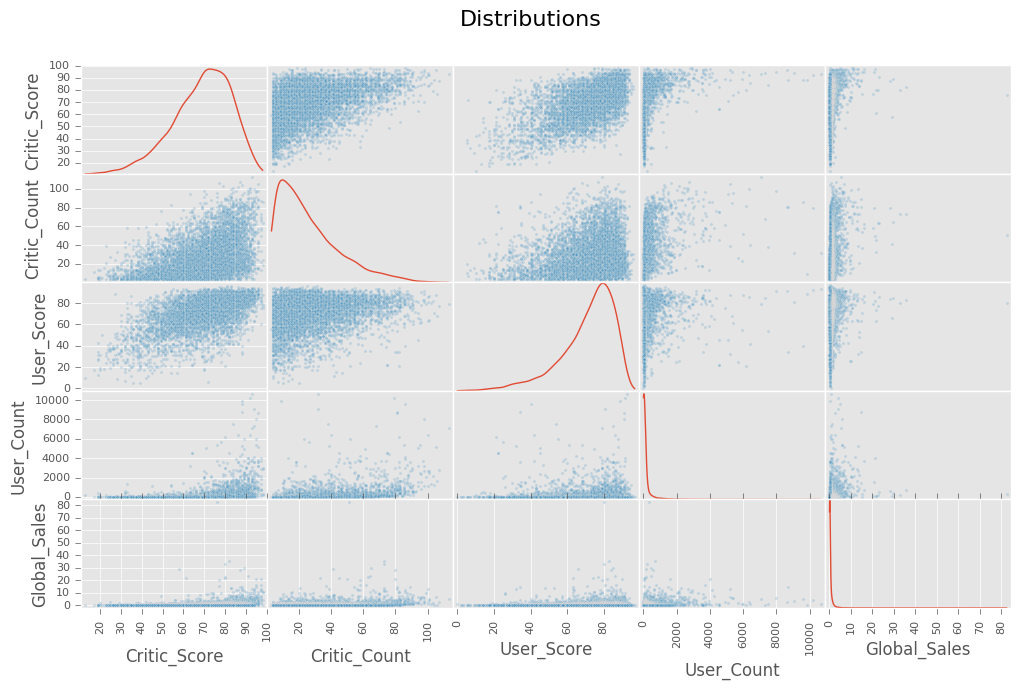

In [44]:
plotDistributions(raw_dataset, 'viz/distributions.png')

In [45]:
# Sanitization
clean_dataset = sanitizeDatasets(raw_dataset)

#Prepare for removing rows
short_dataset = clean_dataset.copy()

groups = short_dataset['Global_Sales'].groupby(short_dataset['Year_of_Release'])
display(groups.sum())

# Remove years that are not fit for the analysis
short_dataset = removeOutliersYear(short_dataset.copy())
# Remove titles that have only been sold in Japan
short_dataset = removeOutliersJapanOnly(short_dataset.copy())

# Look for outliers regarding Sales
display(clean_dataset.sort_values(['Global_Sales'], ascending = False).head())

# Remove those games that also came in bundles
short_dataset = removeOutliersBundle(short_dataset.copy(), remove_bundles = False)

Year_of_Release
1985.0      0.03
1988.0      0.03
1992.0      0.03
1994.0      1.27
1996.0     20.10
1997.0     35.01
1998.0     43.18
1999.0     52.21
2000.0     81.24
2001.0    256.32
2002.0    296.78
2003.0    265.62
2004.0    323.79
2005.0    336.95
2006.0    422.86
2007.0    464.15
2008.0    504.09
2009.0    460.48
2010.0    417.33
2011.0    391.79
2012.0    292.82
2013.0    267.78
2014.0    192.43
2015.0    159.16
2016.0     91.60
Name: Global_Sales, dtype: float64

6547 samples remaining after removeOutliersYear().
6474 samples remaining after removeOutliersJapanOnly().


,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,80.0,322.0,Nintendo,E
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,83.0,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,80.0,192.0,Nintendo,E
6,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,11.28,9.14,6.50,2.88,29.80,89.0,65.0,85.0,431.0,Nintendo,E
7,Wii Play,Wii,2006.0,Misc,Nintendo,13.96,9.18,2.93,2.84,28.92,58.0,41.0,66.0,129.0,Nintendo,E


/usr/local/lib/python2.7/dist-packages/pandas/core/indexing.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


6474 samples remaining after removeOutliersBundle().


In [46]:
# For each feature find the data points with extreme high or low values

# We could construct outliers mathematically, but we probably only have representative outliers that should
# remain in the set (Chambers, 1986)

#short_dataset = removeOutliers(short_dataset.copy(), columns = ['Global_Sales'], threshold = 1.5, multeity = 1)
#short_dataset = removeOutliers(short_dataset.copy(), columns = ['Critic_Score', 'Critic_Count', 'User_Score', 'User_Count'], threshold = 1.5, multeity = 2)
display(short_dataset.describe())

,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count
count,6474.000000,6474.000000,6474.000000,6474.000000,6474.000000,6474.000000,6474.000000,6474.000000,6474.000000,6474.000000
mean,2007.351251,0.400093,0.234909,0.059640,0.084310,0.779160,70.000000,29.309391,71.738029,170.570745
std,3.762599,0.980299,0.691119,0.278448,0.275454,1.981469,13.884507,19.120170,14.378777,583.195789
min,2001.000000,0.000000,0.000000,0.000000,0.000000,0.010000,13.000000,3.000000,5.000000,4.000000
25%,2004.000000,0.070000,0.020000,0.000000,0.010000,0.120000,62.000000,15.000000,65.000000,11.000000
50%,2007.000000,0.160000,0.060000,0.000000,0.020000,0.300000,72.000000,25.000000,75.000000,26.000000
75%,2010.000000,0.400000,0.210000,0.010000,0.070000,0.760000,80.000000,40.000000,82.000000,86.000000
max,2015.000000,41.360000,28.960000,6.500000,10.570000,82.530000,98.000000,107.000000,96.000000,10665.000000


In [47]:
# Samples that optically might be outliers and should be checked for being bundles
"""
# Critic Score
set1 = short_dataset[(short_dataset['Global_Sales'] > 10) & (short_dataset['Critic_Score'] > 80)].index.values
set2 = short_dataset[(short_dataset['Global_Sales'] > 5) & (short_dataset['Critic_Score'] <= 80)].index.values

# User Score               
set3 = short_dataset[(short_dataset['Global_Sales'] > 5)].index.values
possible_bundles = np.unique(np.append(np.append(set1, set2), set3))
print 'POSSIBLE BUNDLES'

for ID in clean_dataset.index.values:
    if ID in possible_bundles:
        print '{} {} Bundle'.format(clean_dataset.loc[ID]['Name'], clean_dataset.loc[ID]['Platform'])
        print 'dataset = dataset[dataset.Name != \'{}\'] # ID {} ({})'.format(clean_dataset.loc[ID]['Name'], ID, clean_dataset.loc[ID]['Platform'])
"""        

"\n# Critic Score\nset1 = short_dataset[(short_dataset['Global_Sales'] > 10) & (short_dataset['Critic_Score'] > 80)].index.values\nset2 = short_dataset[(short_dataset['Global_Sales'] > 5) & (short_dataset['Critic_Score'] <= 80)].index.values\n\n# User Score               \nset3 = short_dataset[(short_dataset['Global_Sales'] > 5)].index.values\npossible_bundles = np.unique(np.append(np.append(set1, set2), set3))\nprint 'POSSIBLE BUNDLES'\n\nfor ID in clean_dataset.index.values:\n    if ID in possible_bundles:\n        print '{} {} Bundle'.format(clean_dataset.loc[ID]['Name'], clean_dataset.loc[ID]['Platform'])\n        print 'dataset = dataset[dataset.Name != '{}'] # ID {} ({})'.format(clean_dataset.loc[ID]['Name'], ID, clean_dataset.loc[ID]['Platform'])\n"

In [48]:
# display some infos
print ('REMAINING ROWS IN DATASET: {}'.format(*short_dataset.shape))
print ('Dataset has games from {} unique years'.format(short_dataset['Year_of_Release'].unique().size))

display(short_dataset.sort_values(['Global_Sales'], ascending = False).head(129))

REMAINING ROWS IN DATASET: 6474
Dataset has games from 15 unique years


,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,Bundle
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,80.0,322.0,Nintendo,E,bundle
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,83.0,709.0,Nintendo,E,bundle
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,80.0,192.0,Nintendo,E,bundle
6,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,11.28,9.14,6.50,2.88,29.80,89.0,65.0,85.0,431.0,Nintendo,E,bundle
7,Wii Play,Wii,2006.0,Misc,Nintendo,13.96,9.18,2.93,2.84,28.92,58.0,41.0,66.0,129.0,Nintendo,E,bundle
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,Nintendo,14.44,6.94,4.70,2.24,28.32,87.0,80.0,84.0,594.0,Nintendo,E,bundle
11,Mario Kart DS,DS,2005.0,Racing,Nintendo,9.71,7.47,4.13,1.90,23.21,91.0,64.0,86.0,464.0,Nintendo,E,bundle
13,Wii Fit,Wii,2007.0,Sports,Nintendo,8.92,8.03,3.60,2.15,22.70,80.0,63.0,77.0,146.0,Nintendo,E,bundle
14,Kinect Adventures!,X360,2010.0,Misc,Microsoft Game Studios,15.00,4.89,0.24,1.69,21.81,61.0,45.0,63.0,106.0,Good Science Studio,E,bundle
15,Wii Fit Plus,Wii,2009.0,Sports,Nintendo,9.01,8.49,2.53,1.77,21.79,80.0,33.0,74.0,52.0,Nintendo,E,bundle


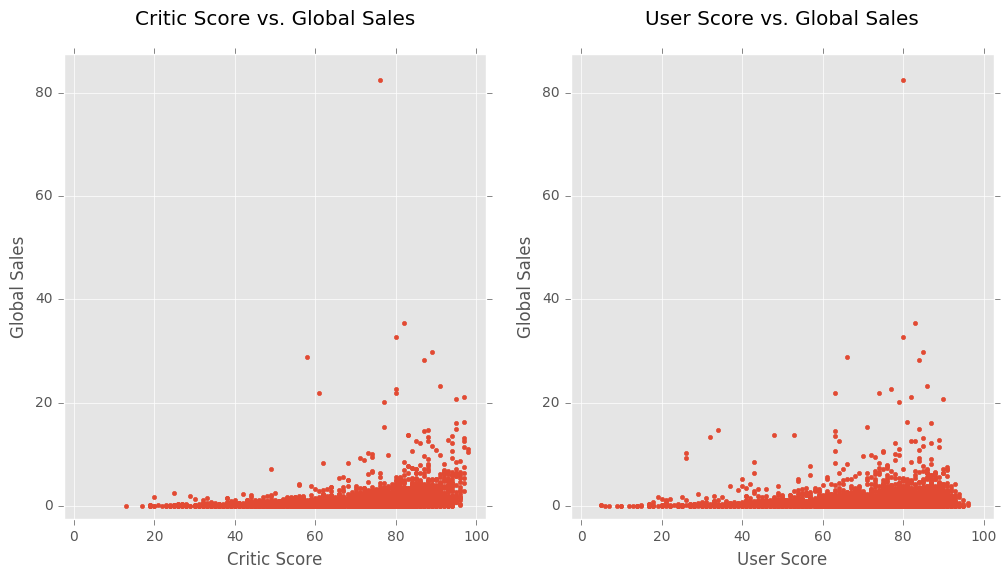

In [49]:
plotScoresVsSales(short_dataset, 'viz/scores_vs_sales_short_dataset.png')

In [50]:
# feature generation and removal

# make feature for "platform manufacturer"
short_dataset = createFeaturePlatformManufacturer(short_dataset)

# make feature for "mobility"
short_dataset = createFeatureMobility(short_dataset)

# Infos
showColumnInfos(short_dataset)

# => too many unique values per feature for the dataset size, so features should be removed
short_dataset = short_dataset.drop(['Name', 'Publisher', 'Developer'], axis=1)

DATASET ROWS: 6474
Unique values for column 'Name': 4086
Unique values for column 'Platform': 16
Unique values for column 'Year_of_Release': 15
Unique values for column 'Genre': 12
Unique values for column 'Publisher': 236
Unique values for column 'NA_Sales': 342
Unique values for column 'EU_Sales': 262
Unique values for column 'JP_Sales': 145
Unique values for column 'Other_Sales': 142
Unique values for column 'Global_Sales': 517
Unique values for column 'Critic_Score': 82
Unique values for column 'Critic_Count': 103
Unique values for column 'User_Score': 89
Unique values for column 'User_Count': 843
Unique values for column 'Developer': 1240
Unique values for column 'Rating': 6
Unique values for column 'Bundle': 2
Unique values for column 'Platform_Manufacturer': 3
Unique values for column 'Mobility': 2


In [51]:
computeSkewness(short_dataset[['Critic_Score', 'Critic_Count', 'User_Score', 'User_Count', 'Global_Sales']])

# transforming years wouldn't make sense (and it randomly is fairly normally distributed)
# transforming sales probably doesn't make sense either, "long tail"
# transforming count might be speculative
# transforming scores might be a way to go

skewness for Critic_Score is: -0.749820471873 (p=3.91459382354e-108)
skewness for Critic_Count is: 0.984370715659 (p=3.80183370613e-165)
skewness for User_Score is: -1.21560794678 (p=1.00382124565e-223)
skewness for User_Count is: 8.84572316462 (p=0.0)
skewness for Global_Sales is: 16.40591074 (p=0.0)


In [52]:
display(short_dataset.head())

,Platform,Year_of_Release,Genre,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Rating,Bundle,Platform_Manufacturer,Mobility
0,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,82.53,76.0,51.0,80.0,322.0,E,bundle,Nintendo,Stationary
2,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,35.52,82.0,73.0,83.0,709.0,E,bundle,Nintendo,Stationary
3,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,32.77,80.0,73.0,80.0,192.0,E,bundle,Nintendo,Stationary
6,DS,2006.0,Platform,11.28,9.14,6.50,2.88,29.80,89.0,65.0,85.0,431.0,E,bundle,Nintendo,Portable
7,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,28.92,58.0,41.0,66.0,129.0,E,bundle,Nintendo,Stationary


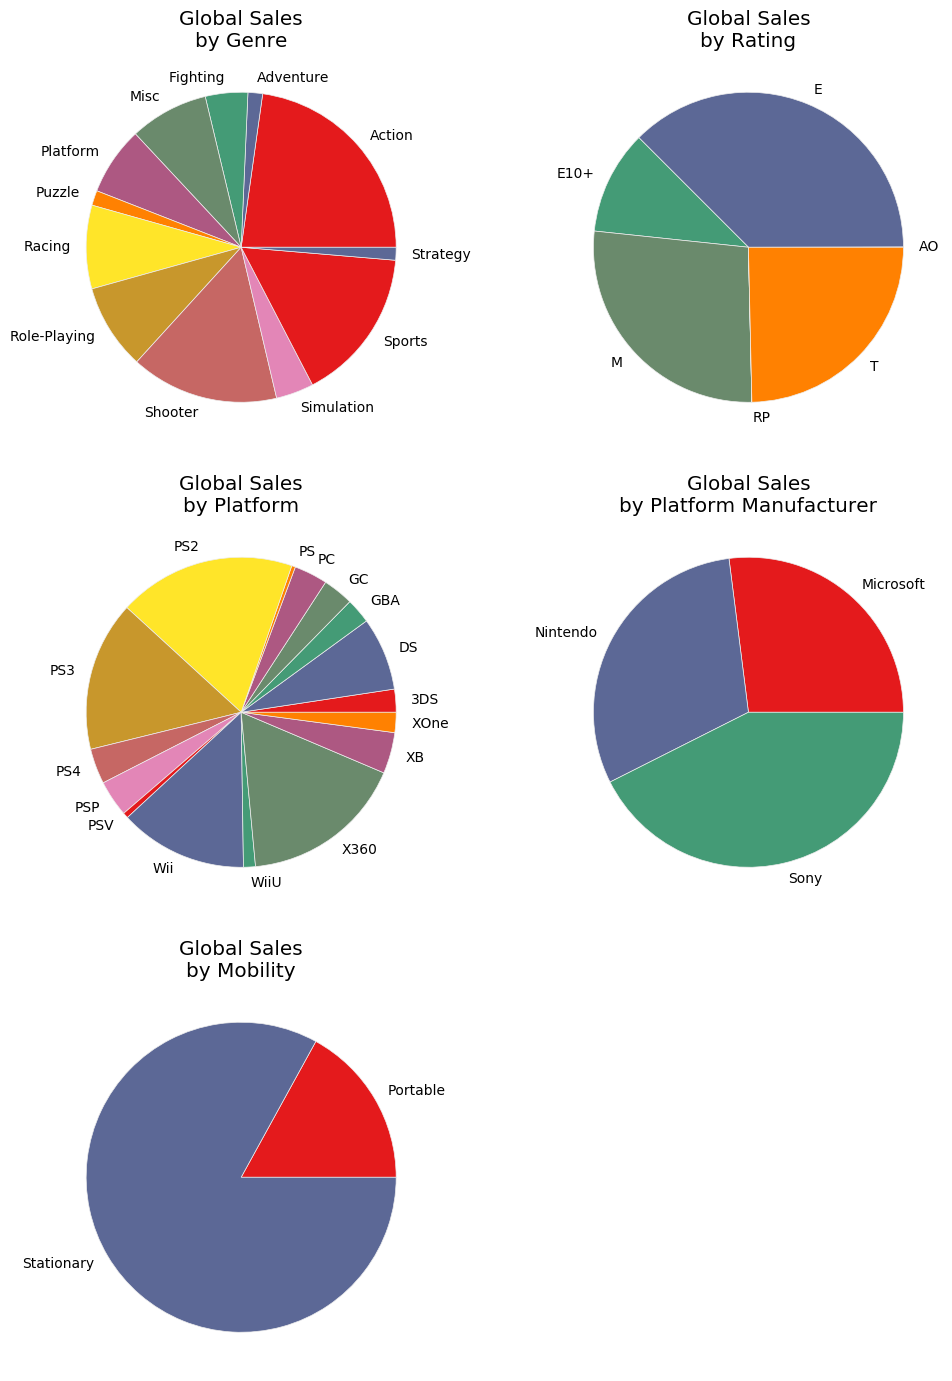

In [53]:
plotSalesByGroup(short_dataset, 'viz/sales_by_groups_short_dataset.png')

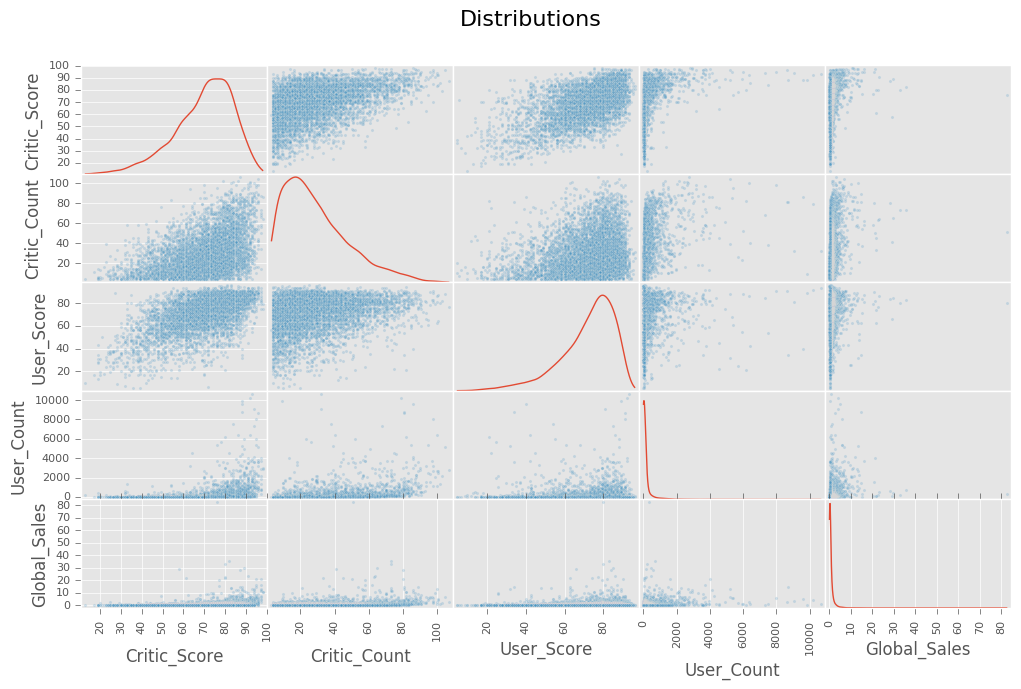

In [54]:
plotDistributions(short_dataset, 'viz/distributions_short_dataset.png')

In [55]:
# convert nominal features to boolean features
short_dataset = convertNominalFeatures(short_dataset.copy(), ['Mobility', 'Platform', 'Genre', 'Rating', 'Platform_Manufacturer', 'Bundle'])
short_dataset = dropNominalFeatures(short_dataset.copy())

In [56]:
# standardize features
#short_dataset, std_scaler = standardizeDataFrame(short_dataset)

# scale features to range [0, 1]
#short_dataset, minmax_scaler = scaleDataFrame(short_dataset)

# run Box-Cox transformation => screws up, better r2, but only for transformed data
#short_dataset, boxcox_lmbdas = boxcoxDataFrame(short_dataset.copy(), columns=['Critic_Score', 'User_Score'])

display(short_dataset.head())

,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,...,Rating_M,Rating_T,Rating_E10+,Rating_AO,Rating_RP,Platform_Manufacturer_Nintendo,Platform_Manufacturer_Microsoft,Platform_Manufacturer_Sony,Bundle_bundle,Bundle_unknown
0,2006.0,41.36,28.96,3.77,8.45,82.53,76.0,51.0,80.0,322.0,...,False,False,False,False,False,True,False,False,True,False
2,2008.0,15.68,12.76,3.79,3.29,35.52,82.0,73.0,83.0,709.0,...,False,False,False,False,False,True,False,False,True,False
3,2009.0,15.61,10.93,3.28,2.95,32.77,80.0,73.0,80.0,192.0,...,False,False,False,False,False,True,False,False,True,False
6,2006.0,11.28,9.14,6.50,2.88,29.80,89.0,65.0,85.0,431.0,...,False,False,False,False,False,True,False,False,True,False
7,2006.0,13.96,9.18,2.93,2.84,28.92,58.0,41.0,66.0,129.0,...,False,False,False,False,False,True,False,False,True,False


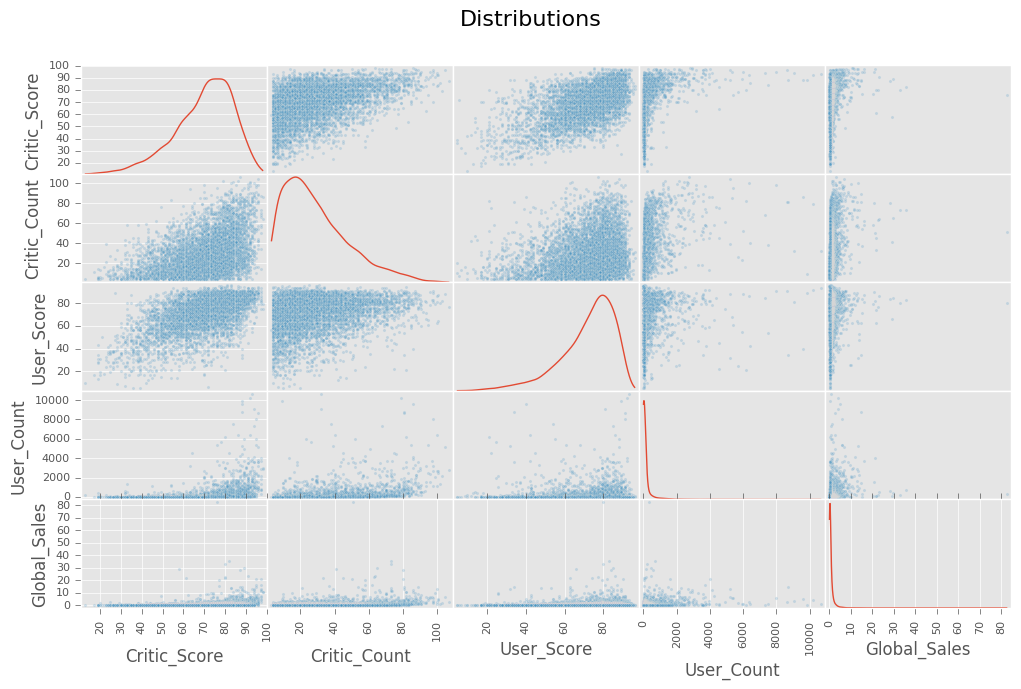

In [57]:
plotDistributions(short_dataset, 'viz/distributions_scaled_transformed_dataset.png')

In [58]:
# split data into training set and test set
# separate features from target values
features, sales = separateTargetValues(short_dataset)
print features.shape, sales.shape

# get five best predictors
showKBest(features, sales['Global'])

# shuffle and split the data into training and testing subsets

# TODO: optional http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
X_train, X_test, y_train, y_test = train_test_split(features, sales['Global'], test_size=0.2, random_state=31415)

# Success
print "Training and testing split was successful: {}/{}".format(X_train.shape, X_test.shape)

(6474, 46) (6474, 5)


,0,1,2,3,4
0,76.0,51.0,322.0,0.0,1.0
1,82.0,73.0,709.0,0.0,1.0
2,80.0,73.0,192.0,0.0,1.0
3,89.0,65.0,431.0,0.0,1.0
4,58.0,41.0,129.0,0.0,1.0


Training and testing split was successful: (5179, 46)/(1295, 46)


time.struct_time(tm_year=2017, tm_mon=3, tm_mday=10, tm_hour=22, tm_min=6, tm_sec=19, tm_wday=4, tm_yday=69, tm_isdst=0)

Now testing ... (5179, 46) vs (1295, 46)
Regressor: Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.460
R² gap: 0.017


/usr/local/lib/python2.7/dist-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


Regressor: SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): 0.184
R² gap: 0.143
Regressor: ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
R² score (train): 0.112
R² gap: 0.105
Regressor: Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
R² score (train): 0.111
R² gap: 0.103


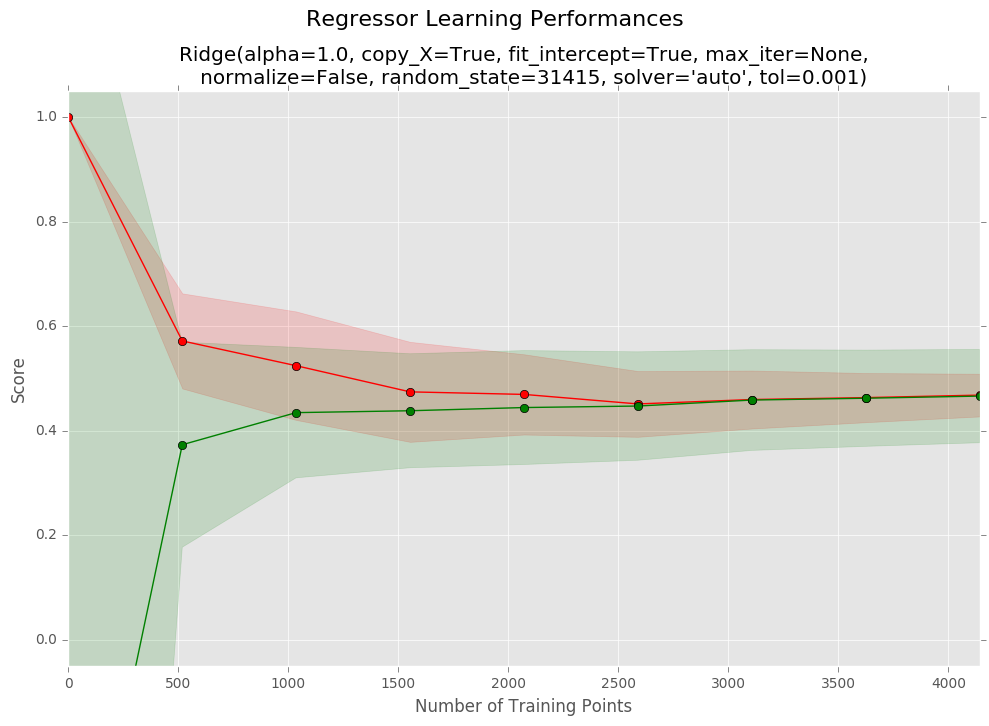

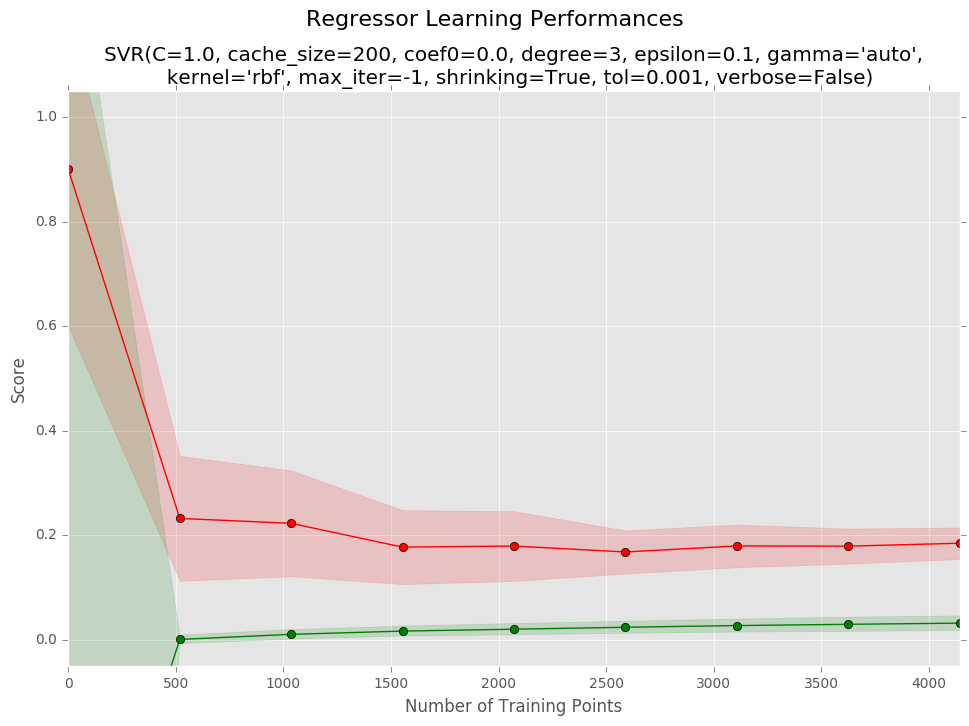

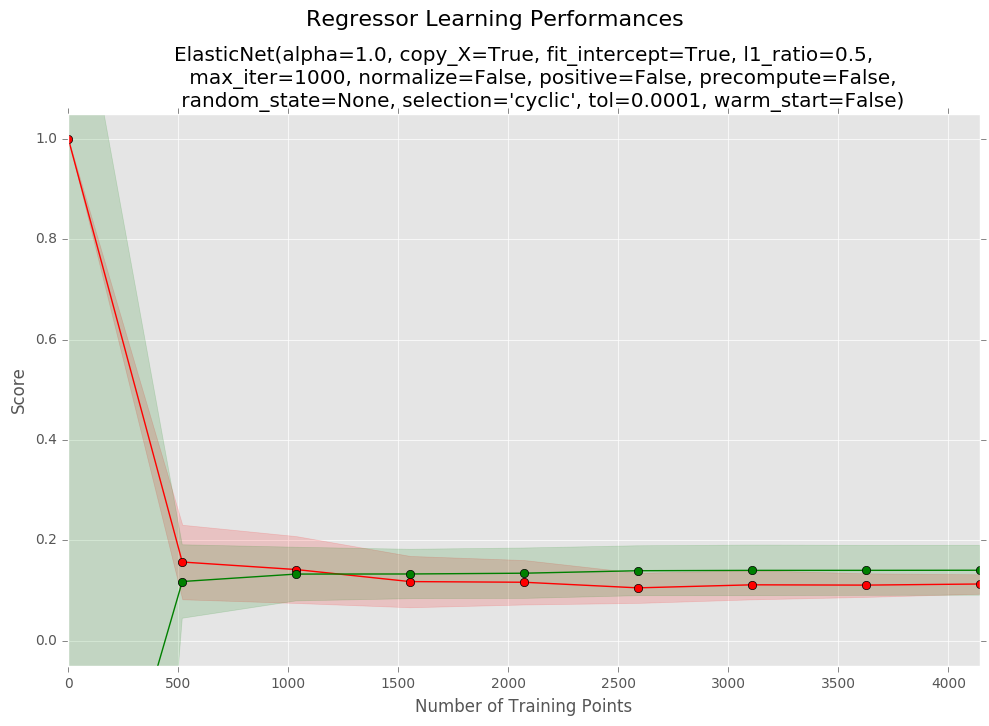

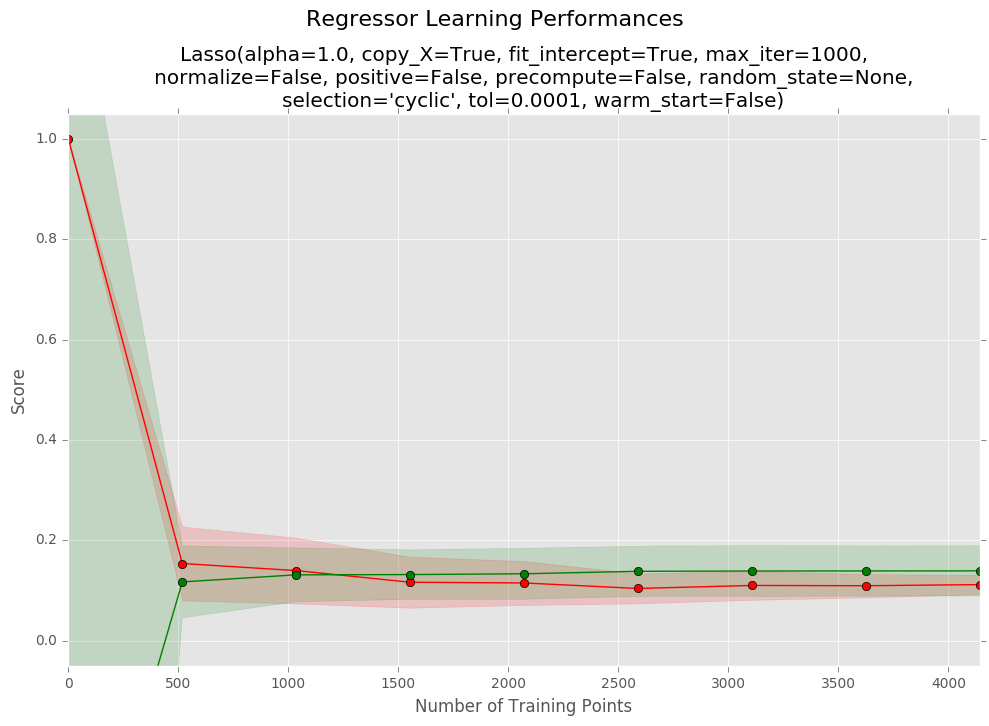

In [59]:
# Check our four algorithm candidates with default values

regressors = [0, 1, 2, 3, 4, 5]
reg_params = [0, 1, 2, 3, 4, 5]

random_state = 31415
n_splits = 20
test_size = 0.2

# create a RidgeRegression regressor object
regressor = Ridge(random_state = random_state)
params = {}
regressors[0] = regressor
reg_params[0] = params

# create a support vector regressor object
regressor = svm.SVR()
params = {}       
regressors[1] = regressor
reg_params[1] = params

# create a ElasticNet regressor object
regressor = ElasticNet()
params = {}
regressors[2] = regressor
reg_params[2] = params

# create a LarsLasso regressor object
regressor = Lasso()
params = {}
regressors[3] = regressor
reg_params[3] = params

total_start_time = time.time()
display(time.localtime(total_start_time))

results_columns = ['Regressor', 'R2_Train', 'R2_Test', 'R2_Gap', 'Calc_Time', 'Standardized', 'Scaled_0_1', 'Boxcoxed', 'Outlier_Threshold', 'Outlier_Multiety', 'Test_Size', 'N_Splits', 'RND']
results = pd.DataFrame(columns = results_columns)

print 'Now testing ... {} vs {}'.format(X_train.shape, X_test.shape)

for index in range(4):
#for index in range(len(regressors)):
    start_time = time.time()
    # Fit the training data to the model using grid search
    reg, reg_score_train, reg_score_test, reg_gap = getScores(X_train, y_train, X_test, y_test, regressors[index], reg_params[index], n_splits, test_size, random_state)
    end_time = time.time()
    
    print 'Regressor: {}'.format(reg)
    print 'R² score (train): {:.3f}'.format(reg_score_train)
    print 'R² gap: {:.3f}'.format(reg_gap)
    
    displayLearningCurve(X_train, y_train, reg, n_splits, test_size, random_state, params)

In [68]:
"""
This is the program that also allows to to a grid search over
some of my meta paramaters such as fraction of test size or
the threshold for statistical outliers (if applied at all)
"""
params_standardize_set   = [False, True]
params_scale_set_0_1     = [False, True]
params_boxcox_set        = [False, True]
params_remove_bundles    = [False, True]
params_outlier_threshold = [2.0] #[-1, 1.5, 1.7, 2.0]
params_outlier_multiety  = [1, 2, 3]
params_n_splits          = [20]
params_test_size         = [0.2]
params_random_state      = [31415]

combinations = len(params_standardize_set) * len(params_scale_set_0_1) * len(params_boxcox_set) * len(params_remove_bundles) * len(params_outlier_threshold) * len(params_outlier_multiety) * len(params_n_splits) * len(params_test_size) * len(params_random_state)

results_columns = ['Id', 'Regressor', 'R2_Train', 'R2_Test', 'R2_Gap', 'Calc_Time', 'Standardized', 'Scaled_0_1', 'Boxcoxed', 'Remove_Bundles', 'Outlier_Threshold', 'Outlier_Multiety', 'Test_Size', 'N_Splits', 'RND']
results = pd.DataFrame(columns = results_columns)

rid = 1
best_r2 = (0, -1)
best_gap = (0, -1)

for standardize_set in params_standardize_set:
    for scale_set_0_1 in params_scale_set_0_1:
        for boxcox_set in params_boxcox_set:
            for remove_bundles in params_remove_bundles:
                for outlier_threshold in params_outlier_threshold:
                    for outlier_multiety in params_outlier_multiety:
                        for n_splits in params_n_splits:
                            for test_size in params_test_size:
                                for random_state in params_random_state:
                                    # boxcox does not work on values <= 0
                                    if (boxcox_set == True):
                                        standardize_set = False

                                    # Generate training and test sets
                                    X_train, X_test, y_train, y_test = prepare_sets(standardize_set, scale_set_0_1, boxcox_set, remove_bundles, outlier_threshold, outlier_multiety, n_splits, test_size, random_state)

                                    regressors = [0, 1, 2, 3, 4, 5]
                                    reg_params = [0, 1, 2, 3, 4, 5]

                                    # create a RidgeRegression regressor object
                                    regressor = Ridge(random_state = random_state)
                                    params = {'alpha': [0.3, 0.7, 1.0, 1.3, 1.7],    # positve float
                                              'fit_intercept': [True, False], # boolean
                                              'max_iter': [1000],             # integer
                                              'normalize': [True, False],     # boolean
                                              'solver': ['auto'] # {'auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag'}
                                             }
                                    regressors[0] = regressor
                                    reg_params[0] = params

                                    # create a support vector regressor object
                                    regressor = svm.SVR()
                                    params = {'C': [0.7, 1.0, 1.3],
                                              'kernel': ['rbf'],
                                              'epsilon': [0.1, 0.3, 0.7, 1.0],
                                              'gamma': ['auto']
                                             }       
                                    regressors[1] = regressor
                                    reg_params[1] = params

                                    # create a ElasticNet regressor object
                                    regressor = ElasticNet()
                                    params = {'alpha': [0.3, 0.7, 1.0, 1.3, 1.7],
                                              'l1_ratio': [0, 0.3, 0.7, 1],
                                              'fit_intercept': [True, False],
                                              'normalize': [True, False],
                                              'max_iter' : [1000]
                                             }
                                    regressors[2] = regressor
                                    reg_params[2] = params

                                    # create a Lasso regressor object
                                    regressor = Lasso()
                                    params = {'alpha': [0.3, 0.7, 1.0, 1.3, 1.7],
                                              'fit_intercept': [True, False],
                                              'normalize': [True, False],
                                              'max_iter': [1000]
                                             }
                                    regressors[3] = regressor
                                    reg_params[3] = params

                                    total_start_time = time.time()
                                    display(time.localtime(total_start_time))

                                    for index in range(4):
                                        start_time = time.time()
                                        # Fit the training data to the model using grid search
                                        reg, reg_score_train, reg_score_test, reg_gap = getScores(X_train, y_train, X_test, y_test, regressors[index], reg_params[index], n_splits, test_size, random_state)
                                        end_time = time.time()

                                        print('ID: {} (of {})'.format(rid, combinations * 4))
                                        print('standardize_set={}, scale_set_0_1={}, boxcox_set={}'.format(standardize_set, scale_set_0_1, boxcox_set))
                                        print('remove_bundles={}, outlier_threshold={}, outlier_multiety={}'.format(remove_bundles, outlier_threshold, outlier_multiety))
                                        print('n_splits={}, test_size={}, random_state={}'.format(n_splits, test_size, random_state))
                                        print('X_train.shape={}'.format(X_train.shape))
                                        print('X_test.shape={}'.format(X_test.shape))
                                        print('Regressor: {}'.format(reg))
                                        print('R² score (train): {:.3f}'.format(reg_score_train))
                                        print('R² gap: {:.3f}'.format(reg_gap))
                                        print('==============================')

                                        if ((reg_score_train > best_r2[0]) | (best_r2[1] < 0)):
                                            best_r2 = (reg_score_train, rid)
                                        if ((reg_gap < best_gap[0]) | (best_gap[1] < 0)):
                                            best_gap = (reg_gap, rid)

                                        print('best r2: {} / best gap: {}'.format(best_r2, best_gap))
                                        print('==============================')

                                        #displayLearningCurve(X_train, y_train, reg, n_splits, test_size, random_state, params)

                                        result = pd.DataFrame(
                                            [[
                                                    rid,
                                                    reg,
                                                    reg_score_train,
                                                    reg_score_test,
                                                    reg_gap,
                                                    end_time - start_time,
                                                    standardize_set,
                                                    scale_set_0_1,
                                                    boxcox_set,
                                                    remove_bundles,
                                                    outlier_threshold,
                                                    outlier_multiety,
                                                    test_size,
                                                    n_splits,
                                                    random_state
                                                ]],
                                            columns = results_columns)
                                        results = results.append(result)
                                        rid = rid + 1
 
display(results)
print('BEST R²')
display(results.nlargest(1, 'R2_Train').head())
print('BEST GAP')
display(results.nsmallest(1, 'R2_Gap').head())

results.to_csv('results_large_grid_p4.csv')

6547 samples remaining after removeOutliersYear().
6474 samples remaining after removeOutliersJapanOnly().
6474 samples remaining after removeOutliersBundle().
5267 samples remaining after removeOutliers().


time.struct_time(tm_year=2017, tm_mon=3, tm_mday=11, tm_hour=22, tm_min=19, tm_sec=9, tm_wday=5, tm_yday=70, tm_isdst=0)

ID: 1 (of 192)
standardize_set=False, scale_set_0_1=False, boxcox_set=False
remove_bundles=False, outlier_threshold=2.0, outlier_multiety=1
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(4213, 46)
X_test.shape=(1054, 46)
Regressor: Ridge(alpha=1.7, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.290
R² gap: 0.074
best r2: (0.28990482907362625, 1) / best gap: (0.073576759512735013, 1)
ID: 2 (of 192)
standardize_set=False, scale_set_0_1=False, boxcox_set=False
remove_bundles=False, outlier_threshold=2.0, outlier_multiety=1
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(4213, 46)
X_test.shape=(1054, 46)
Regressor: SVR(C=0.7, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): 0.754
R² gap: 0.692
best r2: (0.75397434304521771, 2) / best gap: (0.073576759512735013, 1)
ID: 3 (of

time.struct_time(tm_year=2017, tm_mon=3, tm_mday=11, tm_hour=22, tm_min=30, tm_sec=31, tm_wday=5, tm_yday=70, tm_isdst=0)

ID: 5 (of 192)
standardize_set=False, scale_set_0_1=False, boxcox_set=False
remove_bundles=False, outlier_threshold=2.0, outlier_multiety=2
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(4960, 46)
X_test.shape=(1240, 46)
Regressor: Ridge(alpha=1.7, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.509
R² gap: 0.014
best r2: (0.75397434304521771, 2) / best gap: (0.013891565287175167, 5)
ID: 6 (of 192)
standardize_set=False, scale_set_0_1=False, boxcox_set=False
remove_bundles=False, outlier_threshold=2.0, outlier_multiety=2
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(4960, 46)
X_test.shape=(1240, 46)
Regressor: SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.3, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): 0.294
R² gap: 0.239
best r2: (0.75397434304521771, 2) / best gap: (0.013891565287175167, 5)
ID: 7 (of

time.struct_time(tm_year=2017, tm_mon=3, tm_mday=11, tm_hour=22, tm_min=46, tm_sec=55, tm_wday=5, tm_yday=70, tm_isdst=0)

ID: 9 (of 192)
standardize_set=False, scale_set_0_1=False, boxcox_set=False
remove_bundles=False, outlier_threshold=2.0, outlier_multiety=3
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(5160, 46)
X_test.shape=(1290, 46)
Regressor: Ridge(alpha=0.3, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.467
R² gap: 0.056
best r2: (0.75397434304521771, 2) / best gap: (0.0038400716724028561, 7)
ID: 10 (of 192)
standardize_set=False, scale_set_0_1=False, boxcox_set=False
remove_bundles=False, outlier_threshold=2.0, outlier_multiety=3
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(5160, 46)
X_test.shape=(1290, 46)
Regressor: SVR(C=1.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.3, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): 0.216
R² gap: 0.143
best r2: (0.75397434304521771, 2) / best gap: (0.0038400716724028561, 7)
ID: 11 

time.struct_time(tm_year=2017, tm_mon=3, tm_mday=11, tm_hour=23, tm_min=5, tm_sec=18, tm_wday=5, tm_yday=70, tm_isdst=0)

ID: 13 (of 192)
standardize_set=False, scale_set_0_1=False, boxcox_set=False
remove_bundles=True, outlier_threshold=2.0, outlier_multiety=1
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(4144, 44)
X_test.shape=(1036, 44)
Regressor: Ridge(alpha=1.7, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.290
R² gap: 0.029
best r2: (0.75397434304521771, 2) / best gap: (0.0038400716724028561, 7)
ID: 14 (of 192)
standardize_set=False, scale_set_0_1=False, boxcox_set=False
remove_bundles=True, outlier_threshold=2.0, outlier_multiety=1
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(4144, 44)
X_test.shape=(1036, 44)
Regressor: SVR(C=0.7, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): 0.769
R² gap: 0.689
best r2: (0.76907012620098636, 14) / best gap: (0.0038400716724028561, 7)
ID: 15

time.struct_time(tm_year=2017, tm_mon=3, tm_mday=11, tm_hour=23, tm_min=15, tm_sec=23, tm_wday=5, tm_yday=70, tm_isdst=0)

ID: 17 (of 192)
standardize_set=False, scale_set_0_1=False, boxcox_set=False
remove_bundles=True, outlier_threshold=2.0, outlier_multiety=2
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(4896, 44)
X_test.shape=(1224, 44)
Regressor: Ridge(alpha=1.7, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.218
R² gap: 0.019
best r2: (0.76907012620098636, 14) / best gap: (0.0038400716724028561, 7)
ID: 18 (of 192)
standardize_set=False, scale_set_0_1=False, boxcox_set=False
remove_bundles=True, outlier_threshold=2.0, outlier_multiety=2
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(4896, 44)
X_test.shape=(1224, 44)
Regressor: SVR(C=1.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): 0.704
R² gap: 0.552
best r2: (0.76907012620098636, 14) / best gap: (0.0038400716724028561, 7)
ID: 1

time.struct_time(tm_year=2017, tm_mon=3, tm_mday=11, tm_hour=23, tm_min=30, tm_sec=53, tm_wday=5, tm_yday=70, tm_isdst=0)

ID: 21 (of 192)
standardize_set=False, scale_set_0_1=False, boxcox_set=False
remove_bundles=True, outlier_threshold=2.0, outlier_multiety=3
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(5044, 44)
X_test.shape=(1262, 44)
Regressor: Ridge(alpha=1.7, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.272
R² gap: 0.041
best r2: (0.76907012620098636, 14) / best gap: (0.0038400716724028561, 7)
ID: 22 (of 192)
standardize_set=False, scale_set_0_1=False, boxcox_set=False
remove_bundles=True, outlier_threshold=2.0, outlier_multiety=3
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(5044, 44)
X_test.shape=(1262, 44)
Regressor: SVR(C=1.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.3, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): 0.558
R² gap: 0.428
best r2: (0.76907012620098636, 14) / best gap: (0.0038400716724028561, 7)
ID: 2

time.struct_time(tm_year=2017, tm_mon=3, tm_mday=11, tm_hour=23, tm_min=48, tm_sec=1, tm_wday=5, tm_yday=70, tm_isdst=0)

ID: 25 (of 192)
standardize_set=False, scale_set_0_1=False, boxcox_set=True
remove_bundles=False, outlier_threshold=2.0, outlier_multiety=1
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(4305, 46)
X_test.shape=(1077, 46)
Regressor: Ridge(alpha=1.7, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.292
R² gap: 0.055
best r2: (0.76907012620098636, 14) / best gap: (0.0038400716724028561, 7)
ID: 26 (of 192)
standardize_set=False, scale_set_0_1=False, boxcox_set=True
remove_bundles=False, outlier_threshold=2.0, outlier_multiety=1
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(4305, 46)
X_test.shape=(1077, 46)
Regressor: SVR(C=0.7, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): 0.850
R² gap: 0.848
best r2: (0.85014243667026901, 26) / best gap: (0.0038400716724028561, 7)
ID: 2

time.struct_time(tm_year=2017, tm_mon=3, tm_mday=11, tm_hour=23, tm_min=58, tm_sec=1, tm_wday=5, tm_yday=70, tm_isdst=0)

ID: 29 (of 192)
standardize_set=False, scale_set_0_1=False, boxcox_set=True
remove_bundles=False, outlier_threshold=2.0, outlier_multiety=2
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(4978, 46)
X_test.shape=(1245, 46)
Regressor: Ridge(alpha=0.7, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.487
R² gap: 0.075
best r2: (0.85014243667026901, 26) / best gap: (0.0038400716724028561, 7)
ID: 30 (of 192)
standardize_set=False, scale_set_0_1=False, boxcox_set=True
remove_bundles=False, outlier_threshold=2.0, outlier_multiety=2
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(4978, 46)
X_test.shape=(1245, 46)
Regressor: SVR(C=0.7, cache_size=200, coef0=0.0, degree=3, epsilon=0.3, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): 0.244
R² gap: 0.243
best r2: (0.85014243667026901, 26) / best gap: (0.0038400716724028561, 7)
ID: 31

time.struct_time(tm_year=2017, tm_mon=3, tm_mday=12, tm_hour=0, tm_min=12, tm_sec=53, tm_wday=6, tm_yday=71, tm_isdst=0)

ID: 33 (of 192)
standardize_set=False, scale_set_0_1=False, boxcox_set=True
remove_bundles=False, outlier_threshold=2.0, outlier_multiety=3
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(5162, 46)
X_test.shape=(1291, 46)
Regressor: Ridge(alpha=0.7, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.446
R² gap: 0.019
best r2: (0.85014243667026901, 26) / best gap: (0.0038400716724028561, 7)
ID: 34 (of 192)
standardize_set=False, scale_set_0_1=False, boxcox_set=True
remove_bundles=False, outlier_threshold=2.0, outlier_multiety=3
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(5162, 46)
X_test.shape=(1291, 46)
Regressor: SVR(C=1.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.3, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): 0.207
R² gap: 0.206
best r2: (0.85014243667026901, 26) / best gap: (0.0038400716724028561, 7)
ID: 35

time.struct_time(tm_year=2017, tm_mon=3, tm_mday=12, tm_hour=0, tm_min=29, tm_sec=38, tm_wday=6, tm_yday=71, tm_isdst=0)

ID: 37 (of 192)
standardize_set=False, scale_set_0_1=False, boxcox_set=True
remove_bundles=True, outlier_threshold=2.0, outlier_multiety=1
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(4228, 44)
X_test.shape=(1058, 44)
Regressor: Ridge(alpha=1.7, copy_X=True, fit_intercept=False, max_iter=1000,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.303
R² gap: 0.088
best r2: (0.85014243667026901, 26) / best gap: (0.0038400716724028561, 7)
ID: 38 (of 192)
standardize_set=False, scale_set_0_1=False, boxcox_set=True
remove_bundles=True, outlier_threshold=2.0, outlier_multiety=1
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(4228, 44)
X_test.shape=(1058, 44)
Regressor: SVR(C=0.7, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): 0.866
R² gap: 0.879
best r2: (0.86579858871084325, 38) / best gap: (0.0038400716724028561, 7)
ID: 39 

time.struct_time(tm_year=2017, tm_mon=3, tm_mday=12, tm_hour=0, tm_min=38, tm_sec=53, tm_wday=6, tm_yday=71, tm_isdst=0)

ID: 41 (of 192)
standardize_set=False, scale_set_0_1=False, boxcox_set=True
remove_bundles=True, outlier_threshold=2.0, outlier_multiety=2
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(4908, 44)
X_test.shape=(1227, 44)
Regressor: Ridge(alpha=1.7, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.221
R² gap: 0.042
best r2: (0.86579858871084325, 38) / best gap: (0.0038400716724028561, 7)
ID: 42 (of 192)
standardize_set=False, scale_set_0_1=False, boxcox_set=True
remove_bundles=True, outlier_threshold=2.0, outlier_multiety=2
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(4908, 44)
X_test.shape=(1227, 44)
Regressor: SVR(C=1.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): 0.764
R² gap: 0.772
best r2: (0.86579858871084325, 38) / best gap: (0.0038400716724028561, 7)
ID: 43 

time.struct_time(tm_year=2017, tm_mon=3, tm_mday=12, tm_hour=0, tm_min=52, tm_sec=50, tm_wday=6, tm_yday=71, tm_isdst=0)

ID: 45 (of 192)
standardize_set=False, scale_set_0_1=False, boxcox_set=True
remove_bundles=True, outlier_threshold=2.0, outlier_multiety=3
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(5046, 44)
X_test.shape=(1262, 44)
Regressor: Ridge(alpha=1.7, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.282
R² gap: 0.039
best r2: (0.86579858871084325, 38) / best gap: (0.0038400716724028561, 7)
ID: 46 (of 192)
standardize_set=False, scale_set_0_1=False, boxcox_set=True
remove_bundles=True, outlier_threshold=2.0, outlier_multiety=3
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(5046, 44)
X_test.shape=(1262, 44)
Regressor: SVR(C=0.7, cache_size=200, coef0=0.0, degree=3, epsilon=0.3, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): 0.390
R² gap: 0.386
best r2: (0.86579858871084325, 38) / best gap: (0.0038400716724028561, 7)
ID: 47 

time.struct_time(tm_year=2017, tm_mon=3, tm_mday=12, tm_hour=1, tm_min=8, tm_sec=15, tm_wday=6, tm_yday=71, tm_isdst=0)

ID: 49 (of 192)
standardize_set=False, scale_set_0_1=True, boxcox_set=False
remove_bundles=False, outlier_threshold=2.0, outlier_multiety=1
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(4213, 46)
X_test.shape=(1054, 46)
Regressor: Ridge(alpha=0.3, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.274
R² gap: 0.056
best r2: (0.86579858871084325, 38) / best gap: (0.0038400716724028561, 7)
ID: 50 (of 192)
standardize_set=False, scale_set_0_1=True, boxcox_set=False
remove_bundles=False, outlier_threshold=2.0, outlier_multiety=1
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(4213, 46)
X_test.shape=(1054, 46)
Regressor: SVR(C=0.7, cache_size=200, coef0=0.0, degree=3, epsilon=0.7, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): -2.107
R² gap: 0.508
best r2: (0.86579858871084325, 38) / best gap: (0.0038400716724028561, 7)
ID: 5

time.struct_time(tm_year=2017, tm_mon=3, tm_mday=12, tm_hour=1, tm_min=12, tm_sec=37, tm_wday=6, tm_yday=71, tm_isdst=0)

ID: 53 (of 192)
standardize_set=False, scale_set_0_1=True, boxcox_set=False
remove_bundles=False, outlier_threshold=2.0, outlier_multiety=2
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(4960, 46)
X_test.shape=(1240, 46)
Regressor: Ridge(alpha=1.7, copy_X=True, fit_intercept=False, max_iter=1000,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.508
R² gap: 0.012
best r2: (0.86579858871084325, 38) / best gap: (0.001615201570419611, 52)
ID: 54 (of 192)
standardize_set=False, scale_set_0_1=True, boxcox_set=False
remove_bundles=False, outlier_threshold=2.0, outlier_multiety=2
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(4960, 46)
X_test.shape=(1240, 46)
Regressor: SVR(C=1.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): -36.763
R² gap: 5.122
best r2: (0.86579858871084325, 38) / best gap: (0.001615201570419611, 52)
ID:

time.struct_time(tm_year=2017, tm_mon=3, tm_mday=12, tm_hour=1, tm_min=17, tm_sec=53, tm_wday=6, tm_yday=71, tm_isdst=0)

ID: 57 (of 192)
standardize_set=False, scale_set_0_1=True, boxcox_set=False
remove_bundles=False, outlier_threshold=2.0, outlier_multiety=3
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(5160, 46)
X_test.shape=(1290, 46)
Regressor: Ridge(alpha=0.3, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.467
R² gap: 0.056
best r2: (0.86579858871084325, 38) / best gap: (1.2257262693715631e-07, 56)
ID: 58 (of 192)
standardize_set=False, scale_set_0_1=True, boxcox_set=False
remove_bundles=False, outlier_threshold=2.0, outlier_multiety=3
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(5160, 46)
X_test.shape=(1290, 46)
Regressor: SVR(C=1.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): -2.737
R² gap: 2.367
best r2: (0.86579858871084325, 38) / best gap: (1.2257262693715631e-07, 56)
I

time.struct_time(tm_year=2017, tm_mon=3, tm_mday=12, tm_hour=1, tm_min=23, tm_sec=16, tm_wday=6, tm_yday=71, tm_isdst=0)

ID: 61 (of 192)
standardize_set=False, scale_set_0_1=True, boxcox_set=False
remove_bundles=True, outlier_threshold=2.0, outlier_multiety=1
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(4143, 44)
X_test.shape=(1036, 44)
Regressor: Ridge(alpha=0.3, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.271
R² gap: 0.007
best r2: (0.86579858871084325, 38) / best gap: (1.2257262693715631e-07, 56)
ID: 62 (of 192)
standardize_set=False, scale_set_0_1=True, boxcox_set=False
remove_bundles=True, outlier_threshold=2.0, outlier_multiety=1
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(4143, 44)
X_test.shape=(1036, 44)
Regressor: SVR(C=0.7, cache_size=200, coef0=0.0, degree=3, epsilon=0.3, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): -1.956
R² gap: 0.487
best r2: (0.86579858871084325, 38) / best gap: (1.2257262693715631e-07, 56)
ID:

time.struct_time(tm_year=2017, tm_mon=3, tm_mday=12, tm_hour=1, tm_min=27, tm_sec=24, tm_wday=6, tm_yday=71, tm_isdst=0)

ID: 65 (of 192)
standardize_set=False, scale_set_0_1=True, boxcox_set=False
remove_bundles=True, outlier_threshold=2.0, outlier_multiety=2
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(4894, 44)
X_test.shape=(1224, 44)
Regressor: Ridge(alpha=0.3, copy_X=True, fit_intercept=False, max_iter=1000,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.216
R² gap: 0.030
best r2: (0.86579858871084325, 38) / best gap: (1.2257262693715631e-07, 56)
ID: 66 (of 192)
standardize_set=False, scale_set_0_1=True, boxcox_set=False
remove_bundles=True, outlier_threshold=2.0, outlier_multiety=2
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(4894, 44)
X_test.shape=(1224, 44)
Regressor: SVR(C=1.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): -4.322
R² gap: 0.126
best r2: (0.86579858871084325, 38) / best gap: (1.2257262693715631e-07, 56)
ID

time.struct_time(tm_year=2017, tm_mon=3, tm_mday=12, tm_hour=1, tm_min=32, tm_sec=26, tm_wday=6, tm_yday=71, tm_isdst=0)

ID: 69 (of 192)
standardize_set=False, scale_set_0_1=True, boxcox_set=False
remove_bundles=True, outlier_threshold=2.0, outlier_multiety=3
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(5044, 44)
X_test.shape=(1262, 44)
Regressor: Ridge(alpha=0.3, copy_X=True, fit_intercept=False, max_iter=1000,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.272
R² gap: 0.039
best r2: (0.86579858871084325, 38) / best gap: (1.2257262693715631e-07, 56)
ID: 70 (of 192)
standardize_set=False, scale_set_0_1=True, boxcox_set=False
remove_bundles=True, outlier_threshold=2.0, outlier_multiety=3
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(5044, 44)
X_test.shape=(1262, 44)
Regressor: SVR(C=1.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): -1.545
R² gap: 0.265
best r2: (0.86579858871084325, 38) / best gap: (1.2257262693715631e-07, 56)
ID

time.struct_time(tm_year=2017, tm_mon=3, tm_mday=12, tm_hour=1, tm_min=37, tm_sec=43, tm_wday=6, tm_yday=71, tm_isdst=0)

ID: 73 (of 192)
standardize_set=False, scale_set_0_1=True, boxcox_set=True
remove_bundles=False, outlier_threshold=2.0, outlier_multiety=1
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(4305, 46)
X_test.shape=(1077, 46)
Regressor: Ridge(alpha=0.3, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.276
R² gap: 0.043
best r2: (0.86579858871084325, 38) / best gap: (1.2257262693715631e-07, 56)
ID: 74 (of 192)
standardize_set=False, scale_set_0_1=True, boxcox_set=True
remove_bundles=False, outlier_threshold=2.0, outlier_multiety=1
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(4305, 46)
X_test.shape=(1077, 46)
Regressor: SVR(C=0.7, cache_size=200, coef0=0.0, degree=3, epsilon=0.7, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): -2.165
R² gap: 0.446
best r2: (0.86579858871084325, 38) / best gap: (1.2257262693715631e-07, 56)
ID:

time.struct_time(tm_year=2017, tm_mon=3, tm_mday=12, tm_hour=1, tm_min=42, tm_sec=9, tm_wday=6, tm_yday=71, tm_isdst=0)

ID: 77 (of 192)
standardize_set=False, scale_set_0_1=True, boxcox_set=True
remove_bundles=False, outlier_threshold=2.0, outlier_multiety=2
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(4978, 46)
X_test.shape=(1245, 46)
Regressor: Ridge(alpha=0.7, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.487
R² gap: 0.075
best r2: (0.86579858871084325, 38) / best gap: (1.2257262693715631e-07, 56)
ID: 78 (of 192)
standardize_set=False, scale_set_0_1=True, boxcox_set=True
remove_bundles=False, outlier_threshold=2.0, outlier_multiety=2
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(4978, 46)
X_test.shape=(1245, 46)
Regressor: SVR(C=1.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): -33.926
R² gap: 13.799
best r2: (0.86579858871084325, 38) / best gap: (1.2257262693715631e-07, 56)
I

time.struct_time(tm_year=2017, tm_mon=3, tm_mday=12, tm_hour=1, tm_min=47, tm_sec=22, tm_wday=6, tm_yday=71, tm_isdst=0)

ID: 81 (of 192)
standardize_set=False, scale_set_0_1=True, boxcox_set=True
remove_bundles=False, outlier_threshold=2.0, outlier_multiety=3
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(5162, 46)
X_test.shape=(1291, 46)
Regressor: Ridge(alpha=0.7, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.446
R² gap: 0.020
best r2: (0.86579858871084325, 38) / best gap: (1.2257262693715631e-07, 56)
ID: 82 (of 192)
standardize_set=False, scale_set_0_1=True, boxcox_set=True
remove_bundles=False, outlier_threshold=2.0, outlier_multiety=3
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(5162, 46)
X_test.shape=(1291, 46)
Regressor: SVR(C=1.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): -1.480
R² gap: 1.567
best r2: (0.86579858871084325, 38) / best gap: (1.2257262693715631e-07, 56)
ID:

time.struct_time(tm_year=2017, tm_mon=3, tm_mday=12, tm_hour=1, tm_min=52, tm_sec=44, tm_wday=6, tm_yday=71, tm_isdst=0)

ID: 85 (of 192)
standardize_set=False, scale_set_0_1=True, boxcox_set=True
remove_bundles=True, outlier_threshold=2.0, outlier_multiety=1
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(4228, 44)
X_test.shape=(1058, 44)
Regressor: Ridge(alpha=0.3, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.287
R² gap: 0.066
best r2: (0.86579858871084325, 38) / best gap: (1.2257262693715631e-07, 56)
ID: 86 (of 192)
standardize_set=False, scale_set_0_1=True, boxcox_set=True
remove_bundles=True, outlier_threshold=2.0, outlier_multiety=1
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(4228, 44)
X_test.shape=(1058, 44)
Regressor: SVR(C=0.7, cache_size=200, coef0=0.0, degree=3, epsilon=0.3, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): -2.004
R² gap: 0.441
best r2: (0.86579858871084325, 38) / best gap: (1.2257262693715631e-07, 56)
ID: 8

time.struct_time(tm_year=2017, tm_mon=3, tm_mday=12, tm_hour=1, tm_min=56, tm_sec=58, tm_wday=6, tm_yday=71, tm_isdst=0)

ID: 89 (of 192)
standardize_set=False, scale_set_0_1=True, boxcox_set=True
remove_bundles=True, outlier_threshold=2.0, outlier_multiety=2
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(4908, 44)
X_test.shape=(1227, 44)
Regressor: Ridge(alpha=1.3, copy_X=True, fit_intercept=False, max_iter=1000,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.221
R² gap: 0.043
best r2: (0.86579858871084325, 38) / best gap: (1.2257262693715631e-07, 56)
ID: 90 (of 192)
standardize_set=False, scale_set_0_1=True, boxcox_set=True
remove_bundles=True, outlier_threshold=2.0, outlier_multiety=2
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(4908, 44)
X_test.shape=(1227, 44)
Regressor: SVR(C=1.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): -3.874
R² gap: 0.030
best r2: (0.86579858871084325, 38) / best gap: (1.2257262693715631e-07, 56)
ID: 

time.struct_time(tm_year=2017, tm_mon=3, tm_mday=12, tm_hour=2, tm_min=2, tm_sec=2, tm_wday=6, tm_yday=71, tm_isdst=0)

ID: 93 (of 192)
standardize_set=False, scale_set_0_1=True, boxcox_set=True
remove_bundles=True, outlier_threshold=2.0, outlier_multiety=3
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(5046, 44)
X_test.shape=(1262, 44)
Regressor: Ridge(alpha=1.7, copy_X=True, fit_intercept=False, max_iter=1000,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.282
R² gap: 0.028
best r2: (0.86579858871084325, 38) / best gap: (1.2257262693715631e-07, 56)
ID: 94 (of 192)
standardize_set=False, scale_set_0_1=True, boxcox_set=True
remove_bundles=True, outlier_threshold=2.0, outlier_multiety=3
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(5046, 44)
X_test.shape=(1262, 44)
Regressor: SVR(C=1.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): -1.308
R² gap: 0.261
best r2: (0.86579858871084325, 38) / best gap: (1.2257262693715631e-07, 56)
ID: 

time.struct_time(tm_year=2017, tm_mon=3, tm_mday=12, tm_hour=2, tm_min=7, tm_sec=21, tm_wday=6, tm_yday=71, tm_isdst=0)

ID: 97 (of 192)
standardize_set=True, scale_set_0_1=False, boxcox_set=False
remove_bundles=False, outlier_threshold=2.0, outlier_multiety=1
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(4213, 46)
X_test.shape=(1054, 46)
Regressor: Ridge(alpha=1.3, copy_X=True, fit_intercept=False, max_iter=1000,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.290
R² gap: 0.071
best r2: (0.86579858871084325, 38) / best gap: (1.2257262693715631e-07, 56)
ID: 98 (of 192)
standardize_set=True, scale_set_0_1=False, boxcox_set=False
remove_bundles=False, outlier_threshold=2.0, outlier_multiety=1
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(4213, 46)
X_test.shape=(1054, 46)
Regressor: SVR(C=1.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): 0.438
R² gap: 0.193
best r2: (0.86579858871084325, 38) / best gap: (1.2257262693715631e-07, 56)
I

time.struct_time(tm_year=2017, tm_mon=3, tm_mday=12, tm_hour=2, tm_min=13, tm_sec=45, tm_wday=6, tm_yday=71, tm_isdst=0)

ID: 101 (of 192)
standardize_set=True, scale_set_0_1=False, boxcox_set=False
remove_bundles=False, outlier_threshold=2.0, outlier_multiety=2
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(4960, 46)
X_test.shape=(1240, 46)
Regressor: Ridge(alpha=1.7, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.510
R² gap: 0.020
best r2: (0.86579858871084325, 38) / best gap: (1.2257262693715631e-07, 56)
ID: 102 (of 192)
standardize_set=True, scale_set_0_1=False, boxcox_set=False
remove_bundles=False, outlier_threshold=2.0, outlier_multiety=2
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(4960, 46)
X_test.shape=(1240, 46)
Regressor: SVR(C=1.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): 0.528
R² gap: 0.165
best r2: (0.86579858871084325, 38) / best gap: (1.2257262693715631e-07, 56)

time.struct_time(tm_year=2017, tm_mon=3, tm_mday=12, tm_hour=2, tm_min=22, tm_sec=32, tm_wday=6, tm_yday=71, tm_isdst=0)

ID: 105 (of 192)
standardize_set=True, scale_set_0_1=False, boxcox_set=False
remove_bundles=False, outlier_threshold=2.0, outlier_multiety=3
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(5160, 46)
X_test.shape=(1290, 46)
Regressor: Ridge(alpha=1.7, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.475
R² gap: 0.103
best r2: (0.86579858871084325, 38) / best gap: (1.2257262693715631e-07, 56)
ID: 106 (of 192)
standardize_set=True, scale_set_0_1=False, boxcox_set=False
remove_bundles=False, outlier_threshold=2.0, outlier_multiety=3
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(5160, 46)
X_test.shape=(1290, 46)
Regressor: SVR(C=1.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): 0.565
R² gap: 0.057
best r2: (0.86579858871084325, 38) / best gap: (1.2257262693715631e-07, 56)

time.struct_time(tm_year=2017, tm_mon=3, tm_mday=12, tm_hour=2, tm_min=32, tm_sec=20, tm_wday=6, tm_yday=71, tm_isdst=0)

ID: 109 (of 192)
standardize_set=True, scale_set_0_1=False, boxcox_set=False
remove_bundles=True, outlier_threshold=2.0, outlier_multiety=1
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(4144, 44)
X_test.shape=(1036, 44)
Regressor: Ridge(alpha=0.3, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.290
R² gap: 0.028
best r2: (0.86579858871084325, 38) / best gap: (1.2257262693715631e-07, 56)
ID: 110 (of 192)
standardize_set=True, scale_set_0_1=False, boxcox_set=False
remove_bundles=True, outlier_threshold=2.0, outlier_multiety=1
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(4144, 44)
X_test.shape=(1036, 44)
Regressor: SVR(C=1.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): 0.403
R² gap: 0.152
best r2: (0.86579858871084325, 38) / best gap: (1.2257262693715631e-07, 56)
I

time.struct_time(tm_year=2017, tm_mon=3, tm_mday=12, tm_hour=2, tm_min=39, tm_sec=41, tm_wday=6, tm_yday=71, tm_isdst=0)

ID: 113 (of 192)
standardize_set=True, scale_set_0_1=False, boxcox_set=False
remove_bundles=True, outlier_threshold=2.0, outlier_multiety=2
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(4895, 44)
X_test.shape=(1224, 44)
Regressor: Ridge(alpha=1.7, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.218
R² gap: 0.019
best r2: (0.86579858871084325, 38) / best gap: (1.2257262693715631e-07, 56)
ID: 114 (of 192)
standardize_set=True, scale_set_0_1=False, boxcox_set=False
remove_bundles=True, outlier_threshold=2.0, outlier_multiety=2
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(4895, 44)
X_test.shape=(1224, 44)
Regressor: SVR(C=1.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.3, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): 0.335
R² gap: 0.051
best r2: (0.86579858871084325, 38) / best gap: (1.2257262693715631e-07, 56)
I

time.struct_time(tm_year=2017, tm_mon=3, tm_mday=12, tm_hour=2, tm_min=50, tm_sec=0, tm_wday=6, tm_yday=71, tm_isdst=0)

ID: 117 (of 192)
standardize_set=True, scale_set_0_1=False, boxcox_set=False
remove_bundles=True, outlier_threshold=2.0, outlier_multiety=3
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(5044, 44)
X_test.shape=(1261, 44)
Regressor: Ridge(alpha=1.7, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.264
R² gap: 0.008
best r2: (0.86579858871084325, 38) / best gap: (1.2257262693715631e-07, 56)
ID: 118 (of 192)
standardize_set=True, scale_set_0_1=False, boxcox_set=False
remove_bundles=True, outlier_threshold=2.0, outlier_multiety=3
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(5044, 44)
X_test.shape=(1261, 44)
Regressor: SVR(C=1.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.3, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): 0.441
R² gap: 0.122
best r2: (0.86579858871084325, 38) / best gap: (1.2257262693715631e-07, 56)
I

time.struct_time(tm_year=2017, tm_mon=3, tm_mday=12, tm_hour=3, tm_min=1, tm_sec=7, tm_wday=6, tm_yday=71, tm_isdst=0)

ID: 121 (of 192)
standardize_set=False, scale_set_0_1=False, boxcox_set=True
remove_bundles=False, outlier_threshold=2.0, outlier_multiety=1
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(4305, 46)
X_test.shape=(1077, 46)
Regressor: Ridge(alpha=1.7, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.292
R² gap: 0.055
best r2: (0.86579858871084325, 38) / best gap: (1.2257262693715631e-07, 56)
ID: 122 (of 192)
standardize_set=False, scale_set_0_1=False, boxcox_set=True
remove_bundles=False, outlier_threshold=2.0, outlier_multiety=1
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(4305, 46)
X_test.shape=(1077, 46)
Regressor: SVR(C=0.7, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): 0.850
R² gap: 0.848
best r2: (0.86579858871084325, 38) / best gap: (1.2257262693715631e-07, 56)

time.struct_time(tm_year=2017, tm_mon=3, tm_mday=12, tm_hour=3, tm_min=11, tm_sec=8, tm_wday=6, tm_yday=71, tm_isdst=0)

ID: 125 (of 192)
standardize_set=False, scale_set_0_1=False, boxcox_set=True
remove_bundles=False, outlier_threshold=2.0, outlier_multiety=2
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(4978, 46)
X_test.shape=(1245, 46)
Regressor: Ridge(alpha=0.7, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.487
R² gap: 0.075
best r2: (0.86579858871084325, 38) / best gap: (1.2257262693715631e-07, 56)
ID: 126 (of 192)
standardize_set=False, scale_set_0_1=False, boxcox_set=True
remove_bundles=False, outlier_threshold=2.0, outlier_multiety=2
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(4978, 46)
X_test.shape=(1245, 46)
Regressor: SVR(C=0.7, cache_size=200, coef0=0.0, degree=3, epsilon=0.3, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): 0.244
R² gap: 0.243
best r2: (0.86579858871084325, 38) / best gap: (1.2257262693715631e-07, 56)


time.struct_time(tm_year=2017, tm_mon=3, tm_mday=12, tm_hour=3, tm_min=26, tm_sec=0, tm_wday=6, tm_yday=71, tm_isdst=0)

ID: 129 (of 192)
standardize_set=False, scale_set_0_1=False, boxcox_set=True
remove_bundles=False, outlier_threshold=2.0, outlier_multiety=3
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(5162, 46)
X_test.shape=(1291, 46)
Regressor: Ridge(alpha=0.7, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.446
R² gap: 0.019
best r2: (0.86579858871084325, 38) / best gap: (1.2257262693715631e-07, 56)
ID: 130 (of 192)
standardize_set=False, scale_set_0_1=False, boxcox_set=True
remove_bundles=False, outlier_threshold=2.0, outlier_multiety=3
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(5162, 46)
X_test.shape=(1291, 46)
Regressor: SVR(C=1.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.3, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): 0.207
R² gap: 0.206
best r2: (0.86579858871084325, 38) / best gap: (1.2257262693715631e-07, 56)


time.struct_time(tm_year=2017, tm_mon=3, tm_mday=12, tm_hour=3, tm_min=42, tm_sec=44, tm_wday=6, tm_yday=71, tm_isdst=0)

ID: 133 (of 192)
standardize_set=False, scale_set_0_1=False, boxcox_set=True
remove_bundles=True, outlier_threshold=2.0, outlier_multiety=1
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(4228, 44)
X_test.shape=(1058, 44)
Regressor: Ridge(alpha=1.7, copy_X=True, fit_intercept=False, max_iter=1000,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.303
R² gap: 0.088
best r2: (0.86579858871084325, 38) / best gap: (1.2257262693715631e-07, 56)
ID: 134 (of 192)
standardize_set=False, scale_set_0_1=False, boxcox_set=True
remove_bundles=True, outlier_threshold=2.0, outlier_multiety=1
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(4228, 44)
X_test.shape=(1058, 44)
Regressor: SVR(C=0.7, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): 0.866
R² gap: 0.879
best r2: (0.86579858871084325, 38) / best gap: (1.2257262693715631e-07, 56)
I

time.struct_time(tm_year=2017, tm_mon=3, tm_mday=12, tm_hour=3, tm_min=52, tm_sec=0, tm_wday=6, tm_yday=71, tm_isdst=0)

ID: 137 (of 192)
standardize_set=False, scale_set_0_1=False, boxcox_set=True
remove_bundles=True, outlier_threshold=2.0, outlier_multiety=2
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(4908, 44)
X_test.shape=(1227, 44)
Regressor: Ridge(alpha=1.7, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.221
R² gap: 0.042
best r2: (0.86579858871084325, 38) / best gap: (1.2257262693715631e-07, 56)
ID: 138 (of 192)
standardize_set=False, scale_set_0_1=False, boxcox_set=True
remove_bundles=True, outlier_threshold=2.0, outlier_multiety=2
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(4908, 44)
X_test.shape=(1227, 44)
Regressor: SVR(C=1.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): 0.764
R² gap: 0.772
best r2: (0.86579858871084325, 38) / best gap: (1.2257262693715631e-07, 56)
I

time.struct_time(tm_year=2017, tm_mon=3, tm_mday=12, tm_hour=4, tm_min=5, tm_sec=55, tm_wday=6, tm_yday=71, tm_isdst=0)

ID: 141 (of 192)
standardize_set=False, scale_set_0_1=False, boxcox_set=True
remove_bundles=True, outlier_threshold=2.0, outlier_multiety=3
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(5046, 44)
X_test.shape=(1262, 44)
Regressor: Ridge(alpha=1.7, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.282
R² gap: 0.039
best r2: (0.86579858871084325, 38) / best gap: (1.2257262693715631e-07, 56)
ID: 142 (of 192)
standardize_set=False, scale_set_0_1=False, boxcox_set=True
remove_bundles=True, outlier_threshold=2.0, outlier_multiety=3
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(5046, 44)
X_test.shape=(1262, 44)
Regressor: SVR(C=0.7, cache_size=200, coef0=0.0, degree=3, epsilon=0.3, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): 0.390
R² gap: 0.386
best r2: (0.86579858871084325, 38) / best gap: (1.2257262693715631e-07, 56)
I

time.struct_time(tm_year=2017, tm_mon=3, tm_mday=12, tm_hour=4, tm_min=21, tm_sec=18, tm_wday=6, tm_yday=71, tm_isdst=0)

ID: 145 (of 192)
standardize_set=False, scale_set_0_1=True, boxcox_set=False
remove_bundles=False, outlier_threshold=2.0, outlier_multiety=1
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(4213, 46)
X_test.shape=(1054, 46)
Regressor: Ridge(alpha=0.3, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.274
R² gap: 0.056
best r2: (0.86579858871084325, 38) / best gap: (1.2257262693715631e-07, 56)
ID: 146 (of 192)
standardize_set=False, scale_set_0_1=True, boxcox_set=False
remove_bundles=False, outlier_threshold=2.0, outlier_multiety=1
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(4213, 46)
X_test.shape=(1054, 46)
Regressor: SVR(C=0.7, cache_size=200, coef0=0.0, degree=3, epsilon=0.7, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): -2.107
R² gap: 0.508
best r2: (0.86579858871084325, 38) / best gap: (1.2257262693715631e-07, 56)

time.struct_time(tm_year=2017, tm_mon=3, tm_mday=12, tm_hour=4, tm_min=25, tm_sec=38, tm_wday=6, tm_yday=71, tm_isdst=0)

ID: 149 (of 192)
standardize_set=False, scale_set_0_1=True, boxcox_set=False
remove_bundles=False, outlier_threshold=2.0, outlier_multiety=2
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(4960, 46)
X_test.shape=(1240, 46)
Regressor: Ridge(alpha=1.7, copy_X=True, fit_intercept=False, max_iter=1000,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.508
R² gap: 0.012
best r2: (0.86579858871084325, 38) / best gap: (1.2257262693715631e-07, 56)
ID: 150 (of 192)
standardize_set=False, scale_set_0_1=True, boxcox_set=False
remove_bundles=False, outlier_threshold=2.0, outlier_multiety=2
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(4960, 46)
X_test.shape=(1240, 46)
Regressor: SVR(C=1.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): -36.763
R² gap: 5.122
best r2: (0.86579858871084325, 38) / best gap: (1.2257262693715631e-07, 5

time.struct_time(tm_year=2017, tm_mon=3, tm_mday=12, tm_hour=4, tm_min=30, tm_sec=54, tm_wday=6, tm_yday=71, tm_isdst=0)

ID: 153 (of 192)
standardize_set=False, scale_set_0_1=True, boxcox_set=False
remove_bundles=False, outlier_threshold=2.0, outlier_multiety=3
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(5160, 46)
X_test.shape=(1290, 46)
Regressor: Ridge(alpha=0.3, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.467
R² gap: 0.056
best r2: (0.86579858871084325, 38) / best gap: (1.2257262693715631e-07, 56)
ID: 154 (of 192)
standardize_set=False, scale_set_0_1=True, boxcox_set=False
remove_bundles=False, outlier_threshold=2.0, outlier_multiety=3
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(5160, 46)
X_test.shape=(1290, 46)
Regressor: SVR(C=1.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): -2.737
R² gap: 2.367
best r2: (0.86579858871084325, 38) / best gap: (1.2257262693715631e-07, 56)

time.struct_time(tm_year=2017, tm_mon=3, tm_mday=12, tm_hour=4, tm_min=36, tm_sec=16, tm_wday=6, tm_yday=71, tm_isdst=0)

ID: 157 (of 192)
standardize_set=False, scale_set_0_1=True, boxcox_set=False
remove_bundles=True, outlier_threshold=2.0, outlier_multiety=1
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(4143, 44)
X_test.shape=(1036, 44)
Regressor: Ridge(alpha=0.3, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.271
R² gap: 0.007
best r2: (0.86579858871084325, 38) / best gap: (1.2257262693715631e-07, 56)
ID: 158 (of 192)
standardize_set=False, scale_set_0_1=True, boxcox_set=False
remove_bundles=True, outlier_threshold=2.0, outlier_multiety=1
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(4143, 44)
X_test.shape=(1036, 44)
Regressor: SVR(C=0.7, cache_size=200, coef0=0.0, degree=3, epsilon=0.3, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): -1.956
R² gap: 0.487
best r2: (0.86579858871084325, 38) / best gap: (1.2257262693715631e-07, 56)
I

time.struct_time(tm_year=2017, tm_mon=3, tm_mday=12, tm_hour=4, tm_min=40, tm_sec=24, tm_wday=6, tm_yday=71, tm_isdst=0)

ID: 161 (of 192)
standardize_set=False, scale_set_0_1=True, boxcox_set=False
remove_bundles=True, outlier_threshold=2.0, outlier_multiety=2
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(4894, 44)
X_test.shape=(1224, 44)
Regressor: Ridge(alpha=0.3, copy_X=True, fit_intercept=False, max_iter=1000,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.216
R² gap: 0.030
best r2: (0.86579858871084325, 38) / best gap: (1.2257262693715631e-07, 56)
ID: 162 (of 192)
standardize_set=False, scale_set_0_1=True, boxcox_set=False
remove_bundles=True, outlier_threshold=2.0, outlier_multiety=2
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(4894, 44)
X_test.shape=(1224, 44)
Regressor: SVR(C=1.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): -4.322
R² gap: 0.126
best r2: (0.86579858871084325, 38) / best gap: (1.2257262693715631e-07, 56)


time.struct_time(tm_year=2017, tm_mon=3, tm_mday=12, tm_hour=4, tm_min=45, tm_sec=26, tm_wday=6, tm_yday=71, tm_isdst=0)

ID: 165 (of 192)
standardize_set=False, scale_set_0_1=True, boxcox_set=False
remove_bundles=True, outlier_threshold=2.0, outlier_multiety=3
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(5044, 44)
X_test.shape=(1262, 44)
Regressor: Ridge(alpha=0.3, copy_X=True, fit_intercept=False, max_iter=1000,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.272
R² gap: 0.039
best r2: (0.86579858871084325, 38) / best gap: (1.2257262693715631e-07, 56)
ID: 166 (of 192)
standardize_set=False, scale_set_0_1=True, boxcox_set=False
remove_bundles=True, outlier_threshold=2.0, outlier_multiety=3
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(5044, 44)
X_test.shape=(1262, 44)
Regressor: SVR(C=1.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): -1.545
R² gap: 0.265
best r2: (0.86579858871084325, 38) / best gap: (1.2257262693715631e-07, 56)


time.struct_time(tm_year=2017, tm_mon=3, tm_mday=12, tm_hour=4, tm_min=50, tm_sec=43, tm_wday=6, tm_yday=71, tm_isdst=0)

ID: 169 (of 192)
standardize_set=False, scale_set_0_1=True, boxcox_set=True
remove_bundles=False, outlier_threshold=2.0, outlier_multiety=1
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(4305, 46)
X_test.shape=(1077, 46)
Regressor: Ridge(alpha=0.3, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.276
R² gap: 0.043
best r2: (0.86579858871084325, 38) / best gap: (1.2257262693715631e-07, 56)
ID: 170 (of 192)
standardize_set=False, scale_set_0_1=True, boxcox_set=True
remove_bundles=False, outlier_threshold=2.0, outlier_multiety=1
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(4305, 46)
X_test.shape=(1077, 46)
Regressor: SVR(C=0.7, cache_size=200, coef0=0.0, degree=3, epsilon=0.7, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): -2.165
R² gap: 0.446
best r2: (0.86579858871084325, 38) / best gap: (1.2257262693715631e-07, 56)
I

time.struct_time(tm_year=2017, tm_mon=3, tm_mday=12, tm_hour=4, tm_min=55, tm_sec=9, tm_wday=6, tm_yday=71, tm_isdst=0)

ID: 173 (of 192)
standardize_set=False, scale_set_0_1=True, boxcox_set=True
remove_bundles=False, outlier_threshold=2.0, outlier_multiety=2
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(4978, 46)
X_test.shape=(1245, 46)
Regressor: Ridge(alpha=0.7, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.487
R² gap: 0.075
best r2: (0.86579858871084325, 38) / best gap: (1.2257262693715631e-07, 56)
ID: 174 (of 192)
standardize_set=False, scale_set_0_1=True, boxcox_set=True
remove_bundles=False, outlier_threshold=2.0, outlier_multiety=2
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(4978, 46)
X_test.shape=(1245, 46)
Regressor: SVR(C=1.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): -33.926
R² gap: 13.799
best r2: (0.86579858871084325, 38) / best gap: (1.2257262693715631e-07, 56)

time.struct_time(tm_year=2017, tm_mon=3, tm_mday=12, tm_hour=5, tm_min=0, tm_sec=23, tm_wday=6, tm_yday=71, tm_isdst=0)

ID: 177 (of 192)
standardize_set=False, scale_set_0_1=True, boxcox_set=True
remove_bundles=False, outlier_threshold=2.0, outlier_multiety=3
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(5162, 46)
X_test.shape=(1291, 46)
Regressor: Ridge(alpha=0.7, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.446
R² gap: 0.020
best r2: (0.86579858871084325, 38) / best gap: (1.2257262693715631e-07, 56)
ID: 178 (of 192)
standardize_set=False, scale_set_0_1=True, boxcox_set=True
remove_bundles=False, outlier_threshold=2.0, outlier_multiety=3
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(5162, 46)
X_test.shape=(1291, 46)
Regressor: SVR(C=1.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): -1.480
R² gap: 1.567
best r2: (0.86579858871084325, 38) / best gap: (1.2257262693715631e-07, 56)
I

time.struct_time(tm_year=2017, tm_mon=3, tm_mday=12, tm_hour=5, tm_min=5, tm_sec=45, tm_wday=6, tm_yday=71, tm_isdst=0)

ID: 181 (of 192)
standardize_set=False, scale_set_0_1=True, boxcox_set=True
remove_bundles=True, outlier_threshold=2.0, outlier_multiety=1
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(4228, 44)
X_test.shape=(1058, 44)
Regressor: Ridge(alpha=0.3, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.287
R² gap: 0.066
best r2: (0.86579858871084325, 38) / best gap: (1.2257262693715631e-07, 56)
ID: 182 (of 192)
standardize_set=False, scale_set_0_1=True, boxcox_set=True
remove_bundles=True, outlier_threshold=2.0, outlier_multiety=1
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(4228, 44)
X_test.shape=(1058, 44)
Regressor: SVR(C=0.7, cache_size=200, coef0=0.0, degree=3, epsilon=0.3, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): -2.004
R² gap: 0.441
best r2: (0.86579858871084325, 38) / best gap: (1.2257262693715631e-07, 56)
ID:

time.struct_time(tm_year=2017, tm_mon=3, tm_mday=12, tm_hour=5, tm_min=9, tm_sec=57, tm_wday=6, tm_yday=71, tm_isdst=0)

ID: 185 (of 192)
standardize_set=False, scale_set_0_1=True, boxcox_set=True
remove_bundles=True, outlier_threshold=2.0, outlier_multiety=2
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(4908, 44)
X_test.shape=(1227, 44)
Regressor: Ridge(alpha=1.3, copy_X=True, fit_intercept=False, max_iter=1000,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.221
R² gap: 0.043
best r2: (0.86579858871084325, 38) / best gap: (1.2257262693715631e-07, 56)
ID: 186 (of 192)
standardize_set=False, scale_set_0_1=True, boxcox_set=True
remove_bundles=True, outlier_threshold=2.0, outlier_multiety=2
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(4908, 44)
X_test.shape=(1227, 44)
Regressor: SVR(C=1.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): -3.874
R² gap: 0.030
best r2: (0.86579858871084325, 38) / best gap: (1.2257262693715631e-07, 56)
ID

time.struct_time(tm_year=2017, tm_mon=3, tm_mday=12, tm_hour=5, tm_min=15, tm_sec=1, tm_wday=6, tm_yday=71, tm_isdst=0)

ID: 189 (of 192)
standardize_set=False, scale_set_0_1=True, boxcox_set=True
remove_bundles=True, outlier_threshold=2.0, outlier_multiety=3
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(5046, 44)
X_test.shape=(1262, 44)
Regressor: Ridge(alpha=1.7, copy_X=True, fit_intercept=False, max_iter=1000,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.282
R² gap: 0.028
best r2: (0.86579858871084325, 38) / best gap: (1.2257262693715631e-07, 56)
ID: 190 (of 192)
standardize_set=False, scale_set_0_1=True, boxcox_set=True
remove_bundles=True, outlier_threshold=2.0, outlier_multiety=3
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(5046, 44)
X_test.shape=(1262, 44)
Regressor: SVR(C=1.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): -1.308
R² gap: 0.261
best r2: (0.86579858871084325, 38) / best gap: (1.2257262693715631e-07, 56)
ID

,Id,Regressor,R2_Train,R2_Test,R2_Gap,Calc_Time,Standardized,Scaled_0_1,Boxcoxed,Remove_Bundles,Outlier_Threshold,Outlier_Multiety,Test_Size,N_Splits,RND
0,1.0,"Ridge(alpha=1.7, copy_X=True, fit_intercept=Tr...",0.289905,0.216328,0.073577,19.042261,False,False,False,False,2.0,1.0,0.2,20.0,31415.0
0,2.0,"SVR(C=0.7, cache_size=200, coef0=0.0, degree=3...",0.753974,0.062438,0.691537,358.244049,False,False,False,False,2.0,1.0,0.2,20.0,31415.0
0,3.0,"ElasticNet(alpha=0.3, copy_X=True, fit_interce...",0.222940,0.150160,0.072780,284.128131,False,False,False,False,2.0,1.0,0.2,20.0,31415.0
0,4.0,"Lasso(alpha=0.3, copy_X=True, fit_intercept=Tr...",0.140419,0.084512,0.055907,16.254095,False,False,False,False,2.0,1.0,0.2,20.0,31415.0
0,5.0,"Ridge(alpha=1.7, copy_X=True, fit_intercept=Tr...",0.508952,0.495060,0.013892,21.913103,False,False,False,False,2.0,2.0,0.2,20.0,31415.0
0,6.0,"SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...",0.293520,0.054770,0.238750,586.595622,False,False,False,False,2.0,2.0,0.2,20.0,31415.0
0,7.0,"ElasticNet(alpha=0.3, copy_X=True, fit_interce...",0.124306,0.120466,0.003840,350.183026,False,False,False,False,2.0,2.0,0.2,20.0,31415.0
0,8.0,"Lasso(alpha=0.3, copy_X=True, fit_intercept=Fa...",0.059964,0.064445,0.004481,21.945810,False,False,False,False,2.0,2.0,0.2,20.0,31415.0
0,9.0,"Ridge(alpha=0.3, copy_X=True, fit_intercept=Tr...",0.466998,0.411143,0.055855,21.966072,False,False,False,False,2.0,3.0,0.2,20.0,31415.0
0,10.0,"SVR(C=1.3, cache_size=200, coef0=0.0, degree=3...",0.215841,0.073045,0.142796,698.596618,False,False,False,False,2.0,3.0,0.2,20.0,31415.0


BEST R²


,Id,Regressor,R2_Train,R2_Test,R2_Gap,Calc_Time,Standardized,Scaled_0_1,Boxcoxed,Remove_Bundles,Outlier_Threshold,Outlier_Multiety,Test_Size,N_Splits,RND
0,38.0,"SVR(C=0.7, cache_size=200, coef0=0.0, degree=3...",0.865799,-0.013438,0.879237,250.372142,False,False,True,True,2.0,1.0,0.2,20.0,31415.0
0,134.0,"SVR(C=0.7, cache_size=200, coef0=0.0, degree=3...",0.865799,-0.013438,0.879237,250.687234,False,False,True,True,2.0,1.0,0.2,20.0,31415.0
0,26.0,"SVR(C=0.7, cache_size=200, coef0=0.0, degree=3...",0.850142,0.001671,0.848471,278.857191,False,False,True,False,2.0,1.0,0.2,20.0,31415.0
0,122.0,"SVR(C=0.7, cache_size=200, coef0=0.0, degree=3...",0.850142,0.001671,0.848471,279.524936,False,False,True,False,2.0,1.0,0.2,20.0,31415.0
0,14.0,"SVR(C=0.7, cache_size=200, coef0=0.0, degree=3...",0.769070,0.080400,0.688670,302.697336,False,False,False,True,2.0,1.0,0.2,20.0,31415.0


BEST GAP


,Id,Regressor,R2_Train,R2_Test,R2_Gap,Calc_Time,Standardized,Scaled_0_1,Boxcoxed,Remove_Bundles,Outlier_Threshold,Outlier_Multiety,Test_Size,N_Splits,RND
0,56.0,"Lasso(alpha=0.3, copy_X=True, fit_intercept=Tr...",0.0,-1.225726e-07,1.225726e-07,4.535819,False,True,False,False,2.0,2.0,0.2,20.0,31415.0
0,152.0,"Lasso(alpha=0.3, copy_X=True, fit_intercept=Tr...",0.0,-1.225726e-07,1.225726e-07,4.476567,False,True,False,False,2.0,2.0,0.2,20.0,31415.0
0,104.0,"Lasso(alpha=0.3, copy_X=True, fit_intercept=Tr...",0.0,-1.225726e-07,1.225726e-07,4.464771,True,False,False,False,2.0,2.0,0.2,20.0,31415.0
0,72.0,"Lasso(alpha=0.3, copy_X=True, fit_intercept=Tr...",0.0,-3.074377e-06,3.074377e-06,4.495518,False,True,False,True,2.0,3.0,0.2,20.0,31415.0
0,168.0,"Lasso(alpha=0.3, copy_X=True, fit_intercept=Tr...",0.0,-3.074377e-06,3.074377e-06,4.485322,False,True,False,True,2.0,3.0,0.2,20.0,31415.0


In [71]:
results = pd.read_csv("results_large_grid.csv")

display(results[(results['R2_Gap'] <= 0.05) & (results['R2_Train'] > 0.5)].sort_values(['R2_Train'], ascending=False))

"""
display(results['R2_Train'].groupby(results['Standardized']).mean())
display(results['R2_Train'].groupby(results['Scaled_0_1']).mean())
display(results['R2_Train'].groupby(results['Outlier_Threshold']).mean())
display(results['R2_Train'].groupby(results['Outlier_Multiety']).mean())
display(results['R2_Train'].groupby(results['Test_Size']).mean())
display(results['R2_Train'].groupby(results['N_Splits']).mean())

display(results['R2_Gap'].groupby(results['Standardized']).mean())
display(results['R2_Gap'].groupby(results['Scaled_0_1']).mean())
display(results['R2_Gap'].groupby(results['Outlier_Threshold']).mean())
display(results['R2_Gap'].groupby(results['Outlier_Multiety']).mean())
display(results['R2_Gap'].groupby(results['Test_Size']).mean())
display(results['R2_Gap'].groupby(results['N_Splits']).mean())
"""

,Unnamed: 0,Id,Regressor,R2_Train,R2_Test,R2_Gap,Calc_Time,Standardized,Scaled_0_1,Boxcoxed,Remove_Bundles,Outlier_Threshold,Outlier_Multiety,Test_Size,N_Splits,RND
97,0,98,"SVR(C=1.3, cache_size=200, coef0=0.0, degree=3...",0.553025,0.574882,0.021857,269.617612,True,False,False,False,-1.0,1.0,0.2,20.0,31415.0
105,0,106,"SVR(C=1.3, cache_size=200, coef0=0.0, degree=3...",0.553025,0.574882,0.021857,269.300360,True,False,False,False,-1.0,3.0,0.2,20.0,31415.0
101,0,102,"SVR(C=1.3, cache_size=200, coef0=0.0, degree=3...",0.553025,0.574882,0.021857,269.767108,True,False,False,False,-1.0,2.0,0.2,20.0,31415.0
292,0,293,"Ridge(alpha=1.7, copy_X=True, fit_intercept=Tr...",0.521574,0.528186,0.006612,8.930969,True,False,False,False,1.5,2.0,0.2,20.0,31415.0
556,0,557,"Ridge(alpha=1.7, copy_X=True, fit_intercept=Fa...",0.511256,0.552329,0.041073,9.187446,False,True,True,False,1.7,2.0,0.2,20.0,31415.0
460,0,461,"Ridge(alpha=1.7, copy_X=True, fit_intercept=Fa...",0.511256,0.552329,0.041073,9.195578,False,True,True,False,1.7,2.0,0.2,20.0,31415.0
340,0,341,"Ridge(alpha=0.3, copy_X=True, fit_intercept=Tr...",0.510760,0.512243,0.001483,8.983697,False,True,False,False,1.5,2.0,0.2,20.0,31415.0
196,0,197,"Ridge(alpha=0.3, copy_X=True, fit_intercept=Tr...",0.510760,0.512243,0.001483,27.419229,False,False,False,False,1.5,2.0,0.2,20.0,31415.0
244,0,245,"Ridge(alpha=0.3, copy_X=True, fit_intercept=Tr...",0.510760,0.512243,0.001483,9.125505,False,True,False,False,1.5,2.0,0.2,20.0,31415.0
388,0,389,"Ridge(alpha=1.7, copy_X=True, fit_intercept=Tr...",0.510487,0.551805,0.041318,21.042721,False,False,False,False,1.7,2.0,0.2,20.0,31415.0


"\ndisplay(results['R2_Train'].groupby(results['Standardized']).mean())\ndisplay(results['R2_Train'].groupby(results['Scaled_0_1']).mean())\ndisplay(results['R2_Train'].groupby(results['Outlier_Threshold']).mean())\ndisplay(results['R2_Train'].groupby(results['Outlier_Multiety']).mean())\ndisplay(results['R2_Train'].groupby(results['Test_Size']).mean())\ndisplay(results['R2_Train'].groupby(results['N_Splits']).mean())\n\ndisplay(results['R2_Gap'].groupby(results['Standardized']).mean())\ndisplay(results['R2_Gap'].groupby(results['Scaled_0_1']).mean())\ndisplay(results['R2_Gap'].groupby(results['Outlier_Threshold']).mean())\ndisplay(results['R2_Gap'].groupby(results['Outlier_Multiety']).mean())\ndisplay(results['R2_Gap'].groupby(results['Test_Size']).mean())\ndisplay(results['R2_Gap'].groupby(results['N_Splits']).mean())\n"

6547 samples remaining after removeOutliersYear().
6474 samples remaining after removeOutliersJapanOnly().
6474 samples remaining after removeOutliersBundle().
standardize_set=True, scale_set_0_1=False, boxcox_set=False
remove_bundles=False, outlier_threshold=-1, outlier_multiety=1
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(5179, 46)
X_test.shape=(1295, 46)
Regressor: SVR(C=1.74, cache_size=200, coef0=0.0, degree=3, epsilon=0.12, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): 0.591
R² gap: 0.010


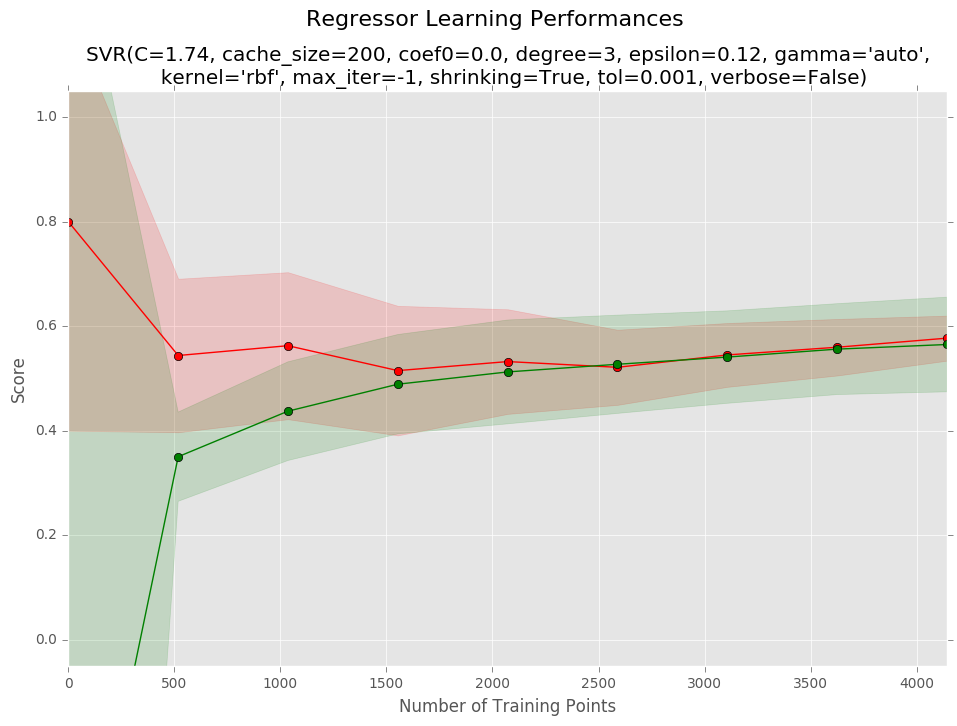

In [85]:
# Tweak SVR results
# C = 1.3; epsilon = 0.1; gamma = auto from previous analysis => R² = 0.553, gap = 0.022
# C = 1.7; epsilon = 0.1; gamma = auto; R² score (train): 0.587, R² gap: 0.008
# C = 1.8; epsilon = 0.1; gamma = auto; R² score (train): 0.594; R² gap: 0.015
# C = 1.73; epsilon = 0.11; gamma = auto; R² score (train): 0.590; R² gap: 0.010
#    C = 1.74; epsilon = 0.12; gamma = auto; R² score (train): 0.591; R² gap: 0.010
# C = 1.75; epsilon = 0.13; gamma = auto; R² score (train): 0.592; R² gap: 0.011
# C = 1.74; epsilon = 0.14; gamma = auto; R² score (train): 0.591; R² gap: 0.010
# C = 1.74; epsilon = 0.15; gamma = auto; R² score (train): 0.592; R² gap: 0.011
# C = 1.74; epsilon = 0.10; gamma = auto; R² score (train): 0.590; R² gap: 0.010

# C: penalty; the higher, the more overfitting
# "Let us suppose that the output values are in the range [0, B]. [...] a value of C about equal to B can be considered to be a robust choice."
# Mattera and Haykin (1999), pages 226-227 in Advances in Kernel Methods

# epsilon: support vectors; the lower, the more overfitting
# "A robust compromise can be to impose the condition that the percentage of Support Vectors be equal to 50%. A larger value of ε can be utilized (especially for very large and/or noisy training sets)..."
# Mattera and Haykin (1999)

# gamma: sphere of influence; the higher, the more overfitting
# Gamma is a parameter for the kernel function. Its default value is setup as gamma = 1 / number of features.

standardize_set   = True
scale_set_0_1     = False
boxcox_set        = False
remove_bundles    = False
outlier_threshold = -1
outlier_multiety  = 1
n_splits          = 20
test_size         = 0.2
random_state      = 31415

X_train, X_test, y_train, y_test = prepare_sets(standardize_set, scale_set_0_1, boxcox_set, remove_bundles, outlier_threshold, outlier_multiety, n_splits, test_size, random_state)

# create a support vector regressor object
regressor = svm.SVR()
params = {'C': [1.74],
          'kernel': ['rbf'],
          'epsilon': [0.12],
          'gamma': ['auto']
         }       

# Fit the training data to the model using grid search
reg, reg_score_train, reg_score_test, reg_gap = getScores(X_train, y_train, X_test, y_test, regressor, params, n_splits, test_size, random_state)

print('standardize_set={}, scale_set_0_1={}, boxcox_set={}'.format(standardize_set, scale_set_0_1, boxcox_set))
print('remove_bundles={}, outlier_threshold={}, outlier_multiety={}'.format(remove_bundles, outlier_threshold, outlier_multiety))
print('n_splits={}, test_size={}, random_state={}'.format(n_splits, test_size, random_state))
print('X_train.shape={}'.format(X_train.shape))
print('X_test.shape={}'.format(X_test.shape))
print('Regressor: {}'.format(reg))
print('R² score (train): {:.3f}'.format(reg_score_train))
print('R² gap: {:.3f}'.format(reg_gap))

displayLearningCurve(X_train, y_train, reg, n_splits, test_size, random_state, params, filename = 'learning_curve.png')

In [89]:
# SVR with best results, when standardized and no bundles / statistical outliers removed

"""
This is the program that also allows to to a grid search over
some of my meta paramaters such as fraction of test size or
the threshold for statistical outliers (if applied at all)
"""
params_standardize_set   = [True]
params_scale_set_0_1     = [False]
params_boxcox_set        = [False]
params_remove_bundles    = [False]
params_outlier_threshold = [-1]
params_outlier_multiety  = [1]
params_n_splits          = [20, 25, 30]
params_test_size         = [0.2, 0.25, 0.3]
params_random_state      = [31415, 42, 123]

combinations = len(params_standardize_set) * len(params_scale_set_0_1) * len(params_boxcox_set) * len(params_remove_bundles) * len(params_outlier_threshold) * len(params_outlier_multiety) * len(params_n_splits) * len(params_test_size) * len(params_random_state)

results_columns = ['Id', 'Regressor', 'R2_Train', 'R2_Test', 'R2_Gap', 'Calc_Time', 'Standardized', 'Scaled_0_1', 'Boxcoxed', 'Remove_Bundles', 'Outlier_Threshold', 'Outlier_Multiety', 'Test_Size', 'N_Splits', 'RND']
results = pd.DataFrame(columns = results_columns)

rid = 1
best_r2 = (0, -1)
best_gap = (0, -1)

for standardize_set in params_standardize_set:
    for scale_set_0_1 in params_scale_set_0_1:
        for boxcox_set in params_boxcox_set:
            for remove_bundles in params_remove_bundles:
                for outlier_threshold in params_outlier_threshold:
                    for outlier_multiety in params_outlier_multiety:
                        for n_splits in params_n_splits:
                            for test_size in params_test_size:
                                for random_state in params_random_state:
                                    # boxcox does not work on values <= 0
                                    if (boxcox_set == True):
                                        standardize_set = False

                                    # Generate training and test sets
                                    X_train, X_test, y_train, y_test = prepare_sets(standardize_set, scale_set_0_1, boxcox_set, remove_bundles, outlier_threshold, outlier_multiety, n_splits, test_size, random_state)

                                    regressors = [0, 1, 2, 3, 4, 5]
                                    reg_params = [0, 1, 2, 3, 4, 5]

                                    # create a support vector regressor object
                                    regressor = svm.SVR()
                                    params = {'C': [1.74],
                                      'kernel': ['rbf'],
                                      'epsilon': [0.12],
                                      'gamma': ['auto']
                                     }        
                                    regressors[0] = regressor
                                    reg_params[0] = params

                                    total_start_time = time.time()
                                    display(time.localtime(total_start_time))

                                    for index in range(1):
                                        start_time = time.time()
                                        # Fit the training data to the model using grid search
                                        reg, reg_score_train, reg_score_test, reg_gap = getScores(X_train, y_train, X_test, y_test, regressors[index], reg_params[index], n_splits, test_size, random_state)
                                        end_time = time.time()

                                        print('ID: {} (of {})'.format(rid, combinations))
                                        print('standardize_set={}, scale_set_0_1={}, boxcox_set={}'.format(standardize_set, scale_set_0_1, boxcox_set))
                                        print('remove_bundles={}, outlier_threshold={}, outlier_multiety={}'.format(remove_bundles, outlier_threshold, outlier_multiety))
                                        print('n_splits={}, test_size={}, random_state={}'.format(n_splits, test_size, random_state))
                                        print('X_train.shape={}'.format(X_train.shape))
                                        print('X_test.shape={}'.format(X_test.shape))
                                        print('Regressor: {}'.format(reg))
                                        print('R² score (train): {:.3f}'.format(reg_score_train))
                                        print('R² gap: {:.3f}'.format(reg_gap))
                                        print('==============================')

                                        if ((reg_score_train > best_r2[0]) | (best_r2[1] < 0)):
                                            best_r2 = (reg_score_train, rid)
                                        if ((reg_gap < best_gap[0]) | (best_gap[1] < 0)):
                                            best_gap = (reg_gap, rid)

                                        print('best r2: {} / best gap: {}'.format(best_r2, best_gap))
                                        print('==============================')

                                        #displayLearningCurve(X_train, y_train, reg, n_splits, test_size, random_state, params)

                                        result = pd.DataFrame(
                                            [[
                                                    rid,
                                                    reg,
                                                    reg_score_train,
                                                    reg_score_test,
                                                    reg_gap,
                                                    end_time - start_time,
                                                    standardize_set,
                                                    scale_set_0_1,
                                                    boxcox_set,
                                                    remove_bundles,
                                                    outlier_threshold,
                                                    outlier_multiety,
                                                    test_size,
                                                    n_splits,
                                                    random_state
                                                ]],
                                            columns = results_columns)
                                        results = results.append(result)
                                        rid = rid + 1
 
display(results)
print('BEST R²')
display(results.nlargest(1, 'R2_Train').head())
print('BEST GAP')
display(results.nsmallest(1, 'R2_Gap').head())

results.to_csv('results_svr_sensitivity.csv')

6547 samples remaining after removeOutliersYear().
6474 samples remaining after removeOutliersJapanOnly().
6474 samples remaining after removeOutliersBundle().


time.struct_time(tm_year=2017, tm_mon=3, tm_mday=12, tm_hour=15, tm_min=0, tm_sec=41, tm_wday=6, tm_yday=71, tm_isdst=0)

ID: 1 (of 1)
standardize_set=True, scale_set_0_1=False, boxcox_set=False
remove_bundles=False, outlier_threshold=-1, outlier_multiety=1
n_splits=50, test_size=0.2, random_state=7
X_train.shape=(5179, 46)
X_test.shape=(1295, 46)
Regressor: SVR(C=1.74, cache_size=200, coef0=0.0, degree=3, epsilon=0.12, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): 0.684
R² gap: 0.294
best r2: (0.68379728454650701, 1) / best gap: (0.29395545470629192, 1)


,Id,Regressor,R2_Train,R2_Test,R2_Gap,Calc_Time,Standardized,Scaled_0_1,Boxcoxed,Remove_Bundles,Outlier_Threshold,Outlier_Multiety,Test_Size,N_Splits,RND
0,1.0,"SVR(C=1.74, cache_size=200, coef0=0.0, degree=...",0.683797,0.389842,0.293955,117.376446,True,False,False,False,-1.0,1.0,0.2,50.0,7.0


BEST R²


,Id,Regressor,R2_Train,R2_Test,R2_Gap,Calc_Time,Standardized,Scaled_0_1,Boxcoxed,Remove_Bundles,Outlier_Threshold,Outlier_Multiety,Test_Size,N_Splits,RND
0,1.0,"SVR(C=1.74, cache_size=200, coef0=0.0, degree=...",0.683797,0.389842,0.293955,117.376446,True,False,False,False,-1.0,1.0,0.2,50.0,7.0


BEST GAP


,Id,Regressor,R2_Train,R2_Test,R2_Gap,Calc_Time,Standardized,Scaled_0_1,Boxcoxed,Remove_Bundles,Outlier_Threshold,Outlier_Multiety,Test_Size,N_Splits,RND
0,1.0,"SVR(C=1.74, cache_size=200, coef0=0.0, degree=...",0.683797,0.389842,0.293955,117.376446,True,False,False,False,-1.0,1.0,0.2,50.0,7.0
